In [1]:
import os
import onnx
import torch

model_dir = os.environ['FINN_ROOT'] + "/notebooks/end2end_example/cnn-dizeratie"
print("Model dir:", model_dir)
torch.set_num_threads(2)

Model dir: /home/stefan/finn/notebooks/end2end_example/cnn-dizeratie


In [2]:
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 KB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 KB 104.7 kB/s eta 0:00:00a 0:00:01


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!mkdir -p data_uta_rldd
!kaggle datasets download -d minhngt02/uta-rldd -p data_uta_rldd --force
!ls data_uta_rldd

Dataset URL: https://www.kaggle.com/datasets/minhngt02/uta-rldd
License(s): CC0-1.0
 99%|█████████████████████████████████████▋| 2.75G/2.77G [00:02<00:00, 1.05GB/s]
100%|███████████████████████████████████████| 2.77G/2.77G [00:03<00:00, 814MB/s]
UTA_RLDD_raw  uta-rldd.zip


In [5]:
!unzip -oq data_uta_rldd/uta-rldd.zip -d data_uta_rldd/UTA_RLDD_raw
print("Unzip completed.")

Unzip completed.


In [6]:
import os
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder

# -------------------------------------------------------
# 1. Root folder where you unzipped the UTA-RLDD Kaggle dataset
#    Adjust this path to match your environment.
# -------------------------------------------------------
uta_root = "data_uta_rldd/UTA_RLDD_raw"   # <-- change if needed

train_root = os.path.join(uta_root, "train")
val_root   = os.path.join(uta_root, "val")
test_root  = os.path.join(uta_root, "test")

# -------------------------------------------------------
# 2. Transforms: resize to 128x128, tensor + normalization
# -------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

# 2) No augmentation, only resize + normalize: VAL/TEST
eval_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                          std=[0.5, 0.5, 0.5]),
# ])

# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
# ])

full_dataset = ImageFolder(root= os.path.join(uta_root, "train") , transform=transform)
# -------------------------------------------------------
# 3. Build train / val / test datasets from folders
# -------------------------------------------------------
train_quantized_dataset = ImageFolder(root=train_root, transform=transform)
val_quantized_dataset   = ImageFolder(root=val_root,   transform=eval_transform)
test_quantized_dataset  = ImageFolder(root=test_root,  transform=eval_transform)

print("Classes:", train_quantized_dataset.classes)
print("Train images:", len(train_quantized_dataset))
print("Val   images:", len(val_quantized_dataset))
print("Test  images:", len(test_quantized_dataset))

# Inspect one sample from train
x0, y0 = train_quantized_dataset[0]
print("Sample shape:", x0.shape)        # (3, 128, 128)
print("Sample label index:", y0)        # 0 or 1
print("Label name:", train_quantized_dataset.classes[y0])
print("Class names:", full_dataset.classes)

Classes: ['active', 'fatigue']
Train images: 9054
Val   images: 1824
Test  images: 909
Sample shape: torch.Size([3, 128, 128])
Sample label index: 0
Label name: active
Class names: ['active', 'fatigue']


Random TRAIN sample:


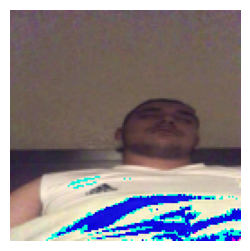

Title: Train sample
Label index: 0
--------------------------------------------------
Random TEST sample:


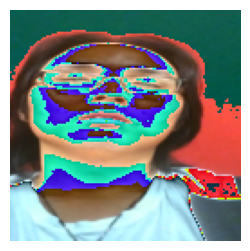

Title: Test sample
Label index: 1
--------------------------------------------------


In [7]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show_random_sample_from_subset(subset, title):
    # subset is a torch.utils.data.Subset
    # subset.dataset is the underlying ImageFolder
    # subset.indices is the list of indices into the ImageFolder

    # pick a random index inside the subset
    subset_idx = random.randint(0, len(subset) - 1)
    # real_idx = subset.indices[subset_idx]   # index inside ImageFolder

    # get image + label
    img, label = subset[subset_idx]

    # get file path
    # filepath, _ = subset.dataset.samples[real_idx]

    # convert tensor to PIL for display
    img_pil = F.to_pil_image(img)

    plt.figure(figsize=(3, 3))
    plt.imshow(img_pil)
    # plt.title(f"{title}\nLabel: {subset.dataset.classes[label]}")
    plt.axis("off")
    plt.show()

    # also print details in text
    print(f"Title: {title}")
    print(f"Label index: {label}")
    # print(f"Label name: {subset.dataset.classes[label]}")
    # print(f"File path: {filepath}")
    print("--------------------------------------------------")


print("Random TRAIN sample:")
show_random_sample_from_subset(train_quantized_dataset, "Train sample")

print("Random TEST sample:")
show_random_sample_from_subset(test_quantized_dataset, "Test sample")


In [8]:
from torch.utils.data import DataLoader

batch_size = 16   # safer for larger images; adjust later if needed

train_quantized_loader = DataLoader(
    train_quantized_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,      # try 4; reduce to 0 if errors
    pin_memory=False
)

test_quantized_loader = DataLoader(
    test_quantized_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=False
)

val_quantized_loader = DataLoader(
    val_quantized_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=False
)

In [9]:
count = 0
for x, y in train_quantized_loader:
    print("Input shape for 1 batch: " + str(x.shape))
    print("Label shape for 1 batch: " + str(y.shape))
    count += 1
    if count == 1:
        break

Input shape for 1 batch: torch.Size([16, 3, 128, 128])
Label shape for 1 batch: torch.Size([16])


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target device: " + str(device))

Target device: cpu


In [11]:
num_classes = len(full_dataset.classes) 
print("Number of classes:", num_classes, "->", full_dataset.classes)

Number of classes: 2 -> ['active', 'fatigue']


In [53]:
#### MODEL 6 #### 

from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN(nn.Module):
    """
    Lighter version of the Keras-style model:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Flatten -> Dropout(0.5) -> Dense(32) -> Dense(num_classes)
    """

    def __init__(self, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()

        # --------- Block 1: 3 -> 16 ---------
        self.conv1 = QuantConv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool1 = nn.MaxPool2d(2, 2)   # H,W: 128 -> 64

        # --------- Block 2: 16 -> 32 ---------
        self.conv2 = QuantConv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act2 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool2 = nn.MaxPool2d(2, 2)   # 64 -> 32

        # --------- Block 3: 32 -> 32 ---------
        self.conv3 = QuantConv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act3 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool3 = nn.MaxPool2d(2, 2)   # 32 -> 16

        # --------- Block 4: 32 -> 32 ---------
        self.conv4 = QuantConv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act4 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool4 = nn.MaxPool2d(2, 2)   # 16 -> 8

        # --------- Compute feature_dim automatically ---------
        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]   # should be 32 * 8 * 8 = 2048 for 128x128

        # --------- Dropout + FC layers ---------
        self.dropout = nn.Dropout(p=0.5)

        self.fc1 = QuantLinear(
            in_features=self.feature_dim,
            out_features=32,   # smaller hidden layer
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act_fc1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )

        self.fc2 = QuantLinear(
            in_features=32,
            out_features=num_classes,   # 2 for drowsy/active
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)   # flatten
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.fc2(x)             # logits
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=input_h,
#     input_width=input_w,
# ).to(device)

# print(model)
# print("feature_dim:", model.feature_dim)

In [13]:
#############################
######## MODEL 6.1 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_1(nn.Module):
    """
    Model 6.1:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Flatten -> Dropout(0.3) -> FC(64) -> ReLU -> Dropout(0.3) -> FC(num_classes)
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 3: 32 -> 32, 32 -> 16
        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Block 4: 32 -> 32, 16 -> 8
        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        # feature dim
        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # for 128: 32*8*8 = 2048

        # Head
        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN_6_1(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=128,
#     input_width=128
# ).to(device)

# print(model.name)
# print("feature_dim:", model.feature_dim)


In [14]:
#############################
######## MODEL 6.2 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_2(nn.Module):
    """
    Model 6.2:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(48) + MaxPool
      Conv(64) + MaxPool
      Flatten -> Dropout(0.3) -> FC(64) -> ReLU -> Dropout(0.3) -> FC(num_classes)
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 3: 32 -> 48, 32 -> 16
        self.conv3 = QuantConv2d(32, 48, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Block 4: 48 -> 64, 16 -> 8
        self.conv4 = QuantConv2d(48, 64, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 64*8*8 = 4096

        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN_6_2(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=128,
#     input_width=128
# ).to(device)

# print(model)
# print("feature_dim:", model.feature_dim)


In [15]:
#############################
######## MODEL 6.3 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_3(nn.Module):
    """
    Model 6.3:
      Same as Model 6 conv widths, but adds Dropout2d(p=0.1) in the conv trunk
      (training-only) + head like 6.1.
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Dropout2d in trunk (training-only)
        self.drop2 = nn.Dropout2d(p=0.1)

        # Block 3: 32 -> 32, 32 -> 16
        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.drop3 = nn.Dropout2d(p=0.1)

        # Block 4: 32 -> 32, 16 -> 8
        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.drop2(x)
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.drop3(x)
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*8*8 = 2048

        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.drop2(x)
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.drop3(x)
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN_6_3(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=128,
#     input_width=128
# ).to(device)

# print(model)
# print("feature_dim:", model.feature_dim)


In [16]:
### Model 8 ### 

from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class Model8_Bottleneck1x1(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        # Block 1: 3 -> 16 -> (1x1) -> 8, pool
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                                 weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.conv1b = QuantConv2d(16, 8, 1, 1, 0, bias=True, weight_bit_width=w_bit,
                                  weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1b  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)  # 128->64

        # Block 2: 8 -> 16 -> (1x1) -> 16, pool
        self.conv2 = QuantConv2d(8, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                                 weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.conv2b = QuantConv2d(16, 16, 1, 1, 0, bias=True, weight_bit_width=w_bit,
                                  weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2b  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)  # 64->32

        # Block 3: 16 -> 32, pool
        self.conv3 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                                 weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)  # 32->16

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1b(self.conv1b(self.act1(self.conv1(dummy)))))
            x = self.pool2(self.act2b(self.conv2b(self.act2(self.conv2(x)))))
            x = self.pool3(self.act3(self.conv3(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1b(self.conv1b(self.act1(self.conv1(x)))))
        x = self.pool2(self.act2b(self.conv2b(self.act2(self.conv2(x)))))
        x = self.pool3(self.act3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [17]:
### Model 9 ### 
class Model9_VGGLite(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        # Stage 1: 3 -> 16 -> 16, pool (128->64)
        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c1b = QuantConv2d(16, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        # Stage 2: 16 -> 32 -> 32, pool (64->32)
        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c2b = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        # Stage 3: 32 -> 48, pool (32->16)
        self.c3 = QuantConv2d(32, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1b(self.c1b(self.a1(self.c1(dummy)))))
            x = self.p2(self.a2b(self.c2b(self.a2(self.c2(x)))))
            x = self.p3(self.a3(self.c3(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1b(self.c1b(self.a1(self.c1(x)))))
        x = self.p2(self.a2b(self.c2b(self.a2(self.c2(x)))))
        x = self.p3(self.a3(self.c3(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [18]:
### Model 10 ###
class Model10_MorePooling(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)  # 128->64

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)  # 64->32

        self.c3 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)  # 32->16

        self.c4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)  # 16->8

        self.c5 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a5 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p5 = nn.MaxPool2d(2,2)  # 8->4  (this is the point)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(dummy)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            x = self.p5(self.a5(self.c5(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*4*4 = 512

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = self.p5(self.a5(self.c5(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [19]:
### Model 11 ### 
class Model11_CappedChannels(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(24, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(24, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)  # 128->64->32->16->8

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(dummy)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*8*8 = 2048

        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [20]:
### Model 12 ###

class Model12_ShrinkBeforeFC(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        
        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)  # 128->64

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)  # 64->32

        self.c3 = QuantConv2d(32, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)  # 32->16

        # 1x1 squeeze: 48 -> 16 (cheap)
        self.squeeze = QuantConv2d(48, 16, 1, 1, 0, bias=True, weight_bit_width=w_bit,
                                   weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_sq = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)  # 16->8

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(dummy)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a_sq(self.squeeze(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 16*8*8 = 1024

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a_sq(self.squeeze(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [21]:
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch


In [22]:
class Model13_VGGmini(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        self.conv1 = QuantConv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            groups=1,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool1 = nn.MaxPool2d(2, 2)   # 128->64

        self.conv2 = QuantConv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            groups=1,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act2 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool2 = nn.MaxPool2d(2, 2)   # 64->32

        self.conv3 = QuantConv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            groups=1,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act3 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool3 = nn.MaxPool2d(2, 2)   # 32->16

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(
            in_features=self.feature_dim,
            out_features=64,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act_fc1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.fc2 = QuantLinear(
            in_features=64,
            out_features=num_classes,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [23]:
class Model14_VGGmini_morepool(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(
            in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)   # 128->64

        self.conv2 = QuantConv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)   # 64->32

        self.conv3 = QuantConv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)   # 32->16

        self.pool4 = nn.MaxPool2d(2, 2)   # 16->8

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(
            in_features=self.feature_dim, out_features=64, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(
            in_features=64, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [24]:
class Model15_2conv_stages(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        # Stage 1
        self.c11 = QuantConv2d(
            in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a11 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c12 = QuantConv2d(
            in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a12 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)  # 128 -> 64

        # Stage 2
        self.c21 = QuantConv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a21 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c22 = QuantConv2d(
            in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a22 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)  # 64 -> 32

        # Stage 3
        self.c31 = QuantConv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a31 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2, 2)  # 32 -> 16

        # feature_dim
        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a12(self.c12(self.a11(self.c11(d)))))
            x = self.p2(self.a22(self.c22(self.a21(self.c21(x)))))
            x = self.p3(self.a31(self.c31(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        # head
        self.fc1 = QuantLinear(
            in_features=self.feature_dim, out_features=64, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(
            in_features=64, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.p1(self.a12(self.c12(self.a11(self.c11(x)))))
        x = self.p2(self.a22(self.c22(self.a21(self.c21(x)))))
        x = self.p3(self.a31(self.c31(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)



In [25]:
class Model16_wide_early(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(
            in_channels=3, out_channels=24, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(
            in_channels=24, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(
            in_channels=32, out_channels=48, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.pool4 = nn.MaxPool2d(2, 2)  # -> 8x8

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(
            in_features=self.feature_dim, out_features=64, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(
            in_features=64, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [26]:
class Model17_deeper_4blocks(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(32, 64, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = QuantConv2d(64, 64, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc = QuantLinear(
            in_features=self.feature_dim, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [27]:
class Model18_bigger_head(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 128, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.fc2 = QuantLinear(128, 64, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.fc3 = QuantLinear(64, num_classes, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.act_fc2(self.fc2(x))
        return self.fc3(x)


In [28]:
class Model19_lowchan_deeper(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.c1 = QuantConv2d(3, 12, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)

        self.c2 = QuantConv2d(12, 16, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)

        self.c3 = QuantConv2d(16, 20, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2, 2)

        self.c4 = QuantConv2d(20, 24, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [29]:
class Model20_all32(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.c1 = QuantConv2d(3, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)

        self.c2 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)

        self.c3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2, 2)

        self.c4 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc = QuantLinear(self.feature_dim, num_classes, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [30]:
class Model21_late64(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = QuantConv2d(32, 64, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [31]:
class Model22_extra_conv_mid(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.c1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)

        self.c2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)

        self.c3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c4 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.p3 = nn.MaxPool2d(2, 2)
        self.p4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.a3(self.c3(x))
            x = self.a4(self.c4(x))
            x = self.p3(x)
            x = self.p4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc = QuantLinear(self.feature_dim, num_classes, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.a3(self.c3(x))
        x = self.a4(self.c4(x))
        x = self.p3(x)
        x = self.p4(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [32]:
class M6_1_WiderEarly(nn.Module):
    def __init__(self, name="M6_1_WiderEarly", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.conv1 = QuantConv2d(3, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2,2)  # 128->64

        self.conv2 = QuantConv2d(24, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2,2)  # 64->32

        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2,2)  # 32->16

        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2,2)  # 16->8

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [33]:
class M6_2_StrongerLate(nn.Module):
    def __init__(self, name="M6_2_StrongerLate", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = QuantConv2d(32, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2,2)

        self.conv4 = QuantConv2d(48, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [34]:
class M6_3_ExtraConvMid(nn.Module):
    def __init__(self, name="M6_3_ExtraConvMid", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c2b = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.a2(self.c2(x))
            x = self.a2b(self.c2b(x))
            x = self.p2(x)
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.a2(self.c2(x))
        x = self.a2b(self.c2b(x))
        x = self.p2(x)
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [35]:
class M6_4_BiggerHead(nn.Module):
    def __init__(self, name="M6_4_BiggerHead", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2,2)

        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [36]:
class M6_5_BottleneckMid(nn.Module):
    def __init__(self, name="M6_5_BottleneckMid", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        # bottleneck: 32 -> 16 (1x1), then 16 -> 32 (3x3)
        self.c2_1x1 = QuantConv2d(32, 16, 1, 1, 0, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2_1x1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c3 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.a2_1x1(self.c2_1x1(x))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.a2_1x1(self.c2_1x1(x))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [37]:
class M13_1_ExtraConvEarly(nn.Module):
    def __init__(self, name="M13_1_ExtraConvEarly", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1a = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1a = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c1b = QuantConv2d(16, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1  = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32, 64, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1b(self.c1b(self.a1a(self.c1a(d)))))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.c1a(x); x = self.a1a(x)
        x = self.c1b(x); x = self.a1b(x)
        x = self.p1(x)
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [38]:
class M13_2_Wider(nn.Module):
    def __init__(self, name="M13_2_Wider", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 40, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(40, 80, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [39]:
class M13_3_Extra1x1Late(nn.Module):
    def __init__(self, name="M13_3_Extra1x1Late", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32, 64, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c3b = QuantConv2d(64, 64, 1, 1, 0, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.a3(self.c3(x))
            x = self.a3b(self.c3b(x))
            x = self.p3(x)
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.a3(self.c3(x))
        x = self.a3b(self.c3b(x))
        x = self.p3(x)
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [40]:
class M13_4_MorePoolBiggerFC(nn.Module):
    def __init__(self, name="M13_4_MorePoolBiggerFC", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3,16,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16,32,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32,64,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.p4 = nn.MaxPool2d(2,2)  # 16->8 (reduces feature_dim)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(x)
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 128, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(128, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(x)
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [41]:
class M13_5_WithDropout(nn.Module):
    def __init__(self, name="M13_5_WithDropout", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3,16,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16,32,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32,64,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = x.view(x.size(0),-1)
        x = self.dropout(x)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [42]:
class M19_1_SlightlyWider(nn.Module):
    def __init__(self, name="M19_1_SlightlyWider", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 14, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(14, 18, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(18, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(24, 30, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [43]:
class M19_2_LastTo32(nn.Module):
    def __init__(self, name="M19_2_LastTo32", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(16, 20, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(20, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc = QuantLinear(self.feature_dim, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        return self.fc(x)


In [44]:
class M19_3_ExtraConvMid(nn.Module):
    def __init__(self, name="M19_3_ExtraConvMid", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c2b = QuantConv2d(16, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(16, 20, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(20, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.a2(self.c2(x))
            x = self.a2b(self.c2b(x))
            x = self.p2(x)
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.a2(self.c2(x))
        x = self.a2b(self.c2b(x))
        x = self.p2(x)
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [45]:
class M19_4_BottleneckBeforeC3(nn.Module):
    def __init__(self, name="M19_4_BottleneckBeforeC3", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c2_1x1 = QuantConv2d(16, 12, 1, 1, 0, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2_1x1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c3 = QuantConv2d(12, 20, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(20, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.a2_1x1(self.c2_1x1(x))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc = QuantLinear(self.feature_dim, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.a2_1x1(self.c2_1x1(x))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        return self.fc(x)


In [46]:
class M19_5_BiggerHead(nn.Module):
    def __init__(self, name="M19_5_BiggerHead", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(16, 20, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(20, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc3 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        x = self.dropout(x)
        x = self.a_fc1(self.fc1(x))
        x = self.a_fc2(self.fc2(x))
        return self.fc3(x)


In [47]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()   
                
        # forward pass
        output = model(inputs.float())      # (batch, num_classes)
        # CrossEntropyLoss expects class indices (0..num_classes-1)
        loss = criterion(output, target.long())
        
        # backward pass + run optimizer to update weights
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.item()) 
           
    return losses


In [48]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, target in loader:
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total


In [49]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

def run_experiment(build_model_fn, exp_name, num_epochs):
    
    model = build_model_fn(num_classes=2, w_bit= 4, a_bit = 4, input_height = 128, input_width = 128).to(device)

    print(f"Model to test: {exp_name}")

    # print(model)
    print("feature_dim:", model.feature_dim)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",          # we want to maximize val accuracy
    factor=0.5,          # multiply LR by 0.5
    patience=5,          # wait 5 epochs with no improvement
    verbose=TrueM13_4_MorePoolBiggerFC
    )
    
    print("Criterion:", criterion)
    print("Optimizer:", optimizer)
    print("Scheduler:", scheduler)

    # %%time
    # x = torch.randn(1, 3, 128, 128).to(device)
    # for i in range(100):
    #     y = model(x)
        
    # %%time
    # batch = next(iter(train_quantized_loader))

    running_loss = []
    running_val_acc = []
    
    best_val_acc = 0.0
    best_state_dict = None
    # best_epoch = -1

    t = trange(num_epochs, desc="Training", leave=True)
    
    for epoch in t:
        
        # --- TRAIN ---
        epoch_losses = train(model, train_quantized_loader, optimizer, criterion)
        train_loss = float(np.mean(epoch_losses))

        # --- VALIDATE ---
        val_acc = evaluate(model, val_quantized_loader, device)

        # LR scheduler (based on validation accuracy)
        scheduler.step(val_acc)

        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        running_loss.append(train_loss)
        running_val_acc.append(val_acc)

        t.set_description(
            f"Epoch {epoch+1}/{num_epochs} loss={train_loss:.4f} val_acc={val_acc:.4f} "
            f"best={best_val_acc:.4f}"
        )
        t.refresh()

    print("Best val accuracy:", best_val_acc)

    # Restore best model (optional but usually a good idea)
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        model.to(device)
        
    test_acc = evaluate(model, test_quantized_loader, device)
    print("Final TEST accuracy:", test_acc)

    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(range(1, len(running_val_acc) + 1), running_loss, color="tab:blue", label="Training loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True)
    
    ax2 = ax1.twinx()
    ax2.plot(range(1, len(running_val_acc) + 1), running_val_acc, color="tab:orange", marker='o', label="Validation accuracy")
    ax2.set_ylabel("Accuracy", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    
    fig.suptitle(exp_name)
    fig.tight_layout()
    plt.show()
    
    del model, optimizer, scheduler
    import gc
    gc.collect()
    torch.cuda.empty_cache()

In [50]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

def run_experiment_new(
    build_model_fn,
    exp_name,
    num_epochs,
    *,
    lr=1e-3,
    weight_decay=1e-4,
    batch_size=None,          # just for logging, since loaders already built
    patience=5,
    factor=0.5,
    min_lr=1e-6,
    seed=0,
):
    # reproducibility per experiment
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = build_model_fn(num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128).to(device)

    print(f"\nModel to test: {exp_name}")
    print("feature_dim:", getattr(model, "feature_dim", "N/A"))
    print(f"lr={lr} wd={weight_decay} patience={patience} factor={factor} min_lr={min_lr} seed={seed} batch={batch_size}")

    criterion = nn.CrossEntropyLoss().to(device)

    # AdamW is often more predictable than Adam when you use weight_decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=factor,
        patience=patience,
        min_lr=min_lr,
        verbose=True
    )

    running_loss = []
    running_val_acc = []
    best_val_acc = 0.0
    best_state_dict = None

    t = trange(num_epochs, desc="Training", leave=True)

    for epoch in t:
        epoch_losses = train(model, train_quantized_loader, optimizer, criterion)
        train_loss = float(np.mean(epoch_losses))

        val_acc = evaluate(model, val_quantized_loader, device)
        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        running_loss.append(train_loss)
        running_val_acc.append(val_acc)

        t.set_description(
            f"Epoch {epoch+1}/{num_epochs} loss={train_loss:.4f} val_acc={val_acc:.4f} best={best_val_acc:.4f}"
        )

    print("Best val accuracy:", best_val_acc)

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        model.to(device)

    test_acc = evaluate(model, test_quantized_loader, device)
    print("Final TEST accuracy:", test_acc)

    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(range(1, len(running_val_acc) + 1), running_loss, color="tab:blue", label="Training loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(range(1, len(running_val_acc) + 1), running_val_acc, color="tab:orange", marker='o', label="Validation accuracy")
    ax2.set_ylabel("Accuracy", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    fig.suptitle(exp_name)
    fig.tight_layout()
    plt.show()

    del model, optimizer, scheduler
    import gc
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return best_val_acc, test_acc


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.



Model to test: Model_6 1e-3
feature_dim: 2048
lr=0.001 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 19/100 loss=0.5570 val_acc=0.6848 best=0.7423:  19%|▏| 19/100 [35:38<2:40:

Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.


Epoch 26/100 loss=0.5480 val_acc=0.7527 best=0.7615:  26%|▎| 26/100 [49:29<2:26:

Epoch 00026: reducing learning rate of group 0 to 2.5000e-04.


Epoch 37/100 loss=0.5419 val_acc=0.7659 best=0.7697:  37%|▎| 37/100 [1:10:51<2:0

Epoch 00037: reducing learning rate of group 0 to 1.2500e-04.


Epoch 43/100 loss=0.5392 val_acc=0.7681 best=0.7697:  43%|▍| 43/100 [1:23:32<1:5

Epoch 00043: reducing learning rate of group 0 to 6.2500e-05.


Epoch 49/100 loss=0.5376 val_acc=0.7604 best=0.7697:  49%|▍| 49/100 [1:36:07<1:4

Epoch 00049: reducing learning rate of group 0 to 3.1250e-05.


Epoch 55/100 loss=0.5385 val_acc=0.7577 best=0.7697:  55%|▌| 55/100 [1:48:39<1:3

Epoch 00055: reducing learning rate of group 0 to 1.5625e-05.


Epoch 61/100 loss=0.5360 val_acc=0.7610 best=0.7697:  61%|▌| 61/100 [2:01:25<1:2

Epoch 00061: reducing learning rate of group 0 to 7.8125e-06.


Epoch 67/100 loss=0.5353 val_acc=0.7577 best=0.7697:  67%|▋| 67/100 [2:13:53<1:0

Epoch 00067: reducing learning rate of group 0 to 3.9063e-06.


Epoch 73/100 loss=0.5358 val_acc=0.7610 best=0.7697:  73%|▋| 73/100 [2:26:28<56:

Epoch 00073: reducing learning rate of group 0 to 1.9531e-06.


Epoch 79/100 loss=0.5353 val_acc=0.7588 best=0.7697:  79%|▊| 79/100 [2:39:00<44:

Epoch 00079: reducing learning rate of group 0 to 9.7656e-07.


Epoch 85/100 loss=0.5358 val_acc=0.7604 best=0.7697:  85%|▊| 85/100 [2:51:26<31:

Epoch 00085: reducing learning rate of group 0 to 4.8828e-07.


Epoch 91/100 loss=0.5362 val_acc=0.7599 best=0.7697:  91%|▉| 91/100 [3:04:04<18:

Epoch 00091: reducing learning rate of group 0 to 2.4414e-07.


Epoch 97/100 loss=0.5359 val_acc=0.7593 best=0.7697:  97%|▉| 97/100 [3:16:48<06:

Epoch 00097: reducing learning rate of group 0 to 1.2207e-07.


Epoch 100/100 loss=0.5367 val_acc=0.7593 best=0.7697: 100%|█| 100/100 [3:23:07<0

Best val accuracy: 0.7697368421052632


Final TEST accuracy: 0.7777777777777778


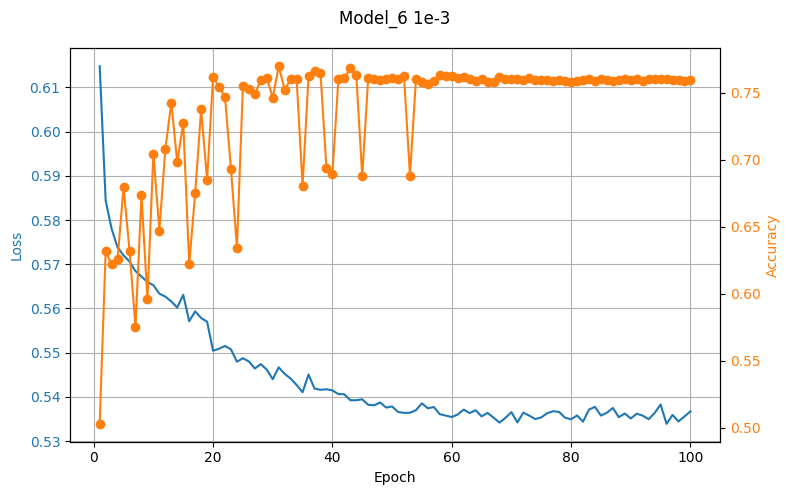

Model to test: Model_6 1e-3
feature_dim: 2048
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x787b30ae27a0>


Epoch 14/100 loss=0.5716 val_acc=0.5548 best=0.7127:  14%|▏| 14/100 [27:16<2:47:

Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 20/100 loss=0.5626 val_acc=0.5894 best=0.7127:  20%|▏| 20/100 [38:53<2:34:

Epoch 00020: reducing learning rate of group 0 to 2.5000e-04.


Epoch 31/100 loss=0.5544 val_acc=0.6469 best=0.7198:  31%|▎| 31/100 [1:00:15<2:1

Epoch 00031: reducing learning rate of group 0 to 1.2500e-04.


Epoch 39/100 loss=0.5532 val_acc=0.6804 best=0.7473:  39%|▍| 39/100 [1:15:50<1:5

Epoch 00039: reducing learning rate of group 0 to 6.2500e-05.


Epoch 45/100 loss=0.5536 val_acc=0.7231 best=0.7473:  45%|▍| 45/100 [1:27:23<1:4

Epoch 00045: reducing learning rate of group 0 to 3.1250e-05.


Epoch 51/100 loss=0.5510 val_acc=0.7319 best=0.7473:  51%|▌| 51/100 [1:38:27<1:3

Epoch 00051: reducing learning rate of group 0 to 1.5625e-05.


Epoch 57/100 loss=0.5488 val_acc=0.7149 best=0.7473:  57%|▌| 57/100 [1:49:17<1:1

Epoch 00057: reducing learning rate of group 0 to 7.8125e-06.


Epoch 66/100 loss=0.5503 val_acc=0.7171 best=0.7505:  66%|▋| 66/100 [2:06:51<1:0

Epoch 00066: reducing learning rate of group 0 to 3.9063e-06.


Epoch 77/100 loss=0.5486 val_acc=0.7127 best=0.7643:  77%|▊| 77/100 [2:28:14<44:

Epoch 00077: reducing learning rate of group 0 to 1.9531e-06.


Epoch 83/100 loss=0.5493 val_acc=0.7193 best=0.7643:  83%|▊| 83/100 [2:39:59<32:

Epoch 00083: reducing learning rate of group 0 to 9.7656e-07.


Epoch 89/100 loss=0.5481 val_acc=0.7484 best=0.7643:  89%|▉| 89/100 [2:51:47<21:

Epoch 00089: reducing learning rate of group 0 to 4.8828e-07.


Epoch 95/100 loss=0.5477 val_acc=0.7215 best=0.7643:  95%|▉| 95/100 [3:03:29<09:

Epoch 00095: reducing learning rate of group 0 to 2.4414e-07.


Epoch 100/100 loss=0.5481 val_acc=0.7643 best=0.7643: 100%|█| 100/100 [3:13:21<0

Best val accuracy: 0.7642543859649122


Final TEST accuracy: 0.757975797579758


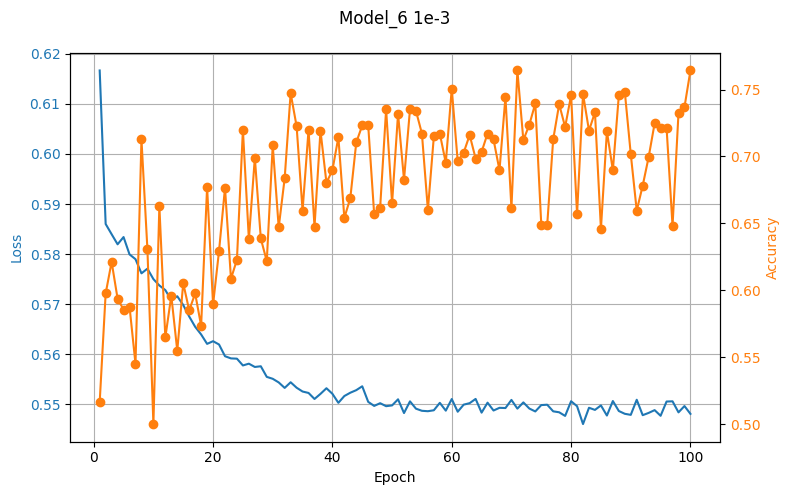


Model to test: Model_6 3e-4
feature_dim: 2048
lr=0.0003 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 20/100 loss=0.5525 val_acc=0.6875 best=0.7566:  20%|▏| 20/100 [40:47<2:41:

Epoch 00020: reducing learning rate of group 0 to 1.5000e-04.


Epoch 26/100 loss=0.5466 val_acc=0.7505 best=0.7566:  26%|▎| 26/100 [52:51<2:29:

Epoch 00026: reducing learning rate of group 0 to 7.5000e-05.


Epoch 33/100 loss=0.5434 val_acc=0.7495 best=0.7588:  33%|▎| 33/100 [1:05:55<2:0

Epoch 00033: reducing learning rate of group 0 to 3.7500e-05.


Epoch 39/100 loss=0.5402 val_acc=0.7094 best=0.7588:  39%|▍| 39/100 [1:16:54<1:5

Epoch 00039: reducing learning rate of group 0 to 1.8750e-05.


Epoch 45/100 loss=0.5387 val_acc=0.7050 best=0.7588:  45%|▍| 45/100 [1:28:23<1:4

Epoch 00045: reducing learning rate of group 0 to 9.3750e-06.


Epoch 51/100 loss=0.5384 val_acc=0.7242 best=0.7588:  51%|▌| 51/100 [1:39:52<1:3

Epoch 00051: reducing learning rate of group 0 to 4.6875e-06.


Epoch 57/100 loss=0.5387 val_acc=0.7067 best=0.7588:  57%|▌| 57/100 [1:51:30<1:2

Epoch 00057: reducing learning rate of group 0 to 2.3437e-06.


Epoch 63/100 loss=0.5380 val_acc=0.7220 best=0.7588:  63%|▋| 63/100 [2:02:57<1:1

Epoch 00063: reducing learning rate of group 0 to 1.1719e-06.


Epoch 69/100 loss=0.5385 val_acc=0.7209 best=0.7588:  69%|▋| 69/100 [2:14:28<58:

Epoch 00069: reducing learning rate of group 0 to 5.8594e-07.


Epoch 75/100 loss=0.5390 val_acc=0.7094 best=0.7588:  75%|▊| 75/100 [2:25:53<47:

Epoch 00075: reducing learning rate of group 0 to 2.9297e-07.


Epoch 81/100 loss=0.5404 val_acc=0.7231 best=0.7588:  81%|▊| 81/100 [2:37:28<36:

Epoch 00081: reducing learning rate of group 0 to 1.4648e-07.


Epoch 87/100 loss=0.5377 val_acc=0.7259 best=0.7588:  87%|▊| 87/100 [2:48:54<24:

Epoch 00087: reducing learning rate of group 0 to 7.3242e-08.


Epoch 93/100 loss=0.5402 val_acc=0.7105 best=0.7588:  93%|▉| 93/100 [3:00:28<13:

Epoch 00093: reducing learning rate of group 0 to 3.6621e-08.


Epoch 99/100 loss=0.5390 val_acc=0.7286 best=0.7588:  99%|▉| 99/100 [3:12:00<01:

Epoch 00099: reducing learning rate of group 0 to 1.8311e-08.


Epoch 100/100 loss=0.5386 val_acc=0.7270 best=0.7588: 100%|█| 100/100 [3:13:58<0

Best val accuracy: 0.7587719298245614


Final TEST accuracy: 0.7634763476347635


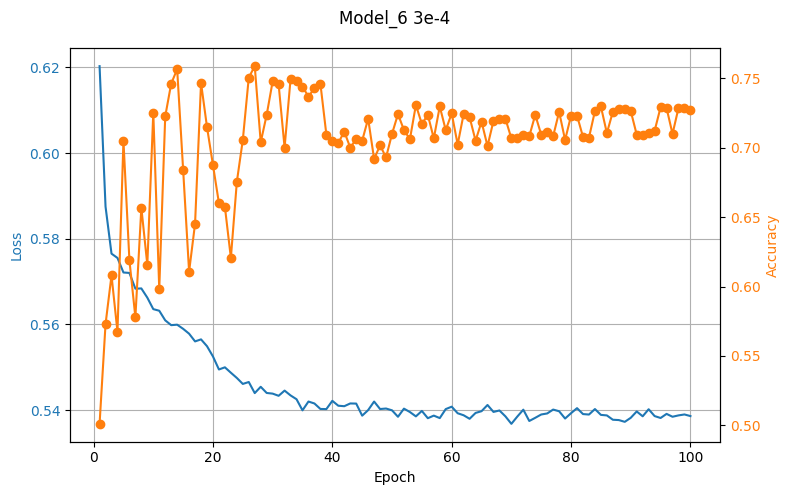


Model to test: Model_6 5e-4
feature_dim: 2048
lr=0.0005 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 19/100 loss=0.5511 val_acc=0.7489 best=0.7489:  19%|▏| 19/100 [35:27<2:30:

Epoch 00019: reducing learning rate of group 0 to 2.5000e-04.


Epoch 25/100 loss=0.5427 val_acc=0.6228 best=0.7489:  25%|▎| 25/100 [46:29<2:17:

Epoch 00025: reducing learning rate of group 0 to 1.2500e-04.


Epoch 31/100 loss=0.5408 val_acc=0.6924 best=0.7489:  31%|▎| 31/100 [57:37<2:08:

Epoch 00031: reducing learning rate of group 0 to 6.2500e-05.


Epoch 37/100 loss=0.5349 val_acc=0.7061 best=0.7489:  37%|▎| 37/100 [1:08:36<1:5

Epoch 00037: reducing learning rate of group 0 to 3.1250e-05.


Epoch 43/100 loss=0.5357 val_acc=0.6820 best=0.7489:  43%|▍| 43/100 [1:19:48<1:4

Epoch 00043: reducing learning rate of group 0 to 1.5625e-05.


Epoch 49/100 loss=0.5360 val_acc=0.6979 best=0.7489:  49%|▍| 49/100 [1:30:51<1:3

Epoch 00049: reducing learning rate of group 0 to 7.8125e-06.


Epoch 55/100 loss=0.5352 val_acc=0.6974 best=0.7489:  55%|▌| 55/100 [1:42:00<1:2

Epoch 00055: reducing learning rate of group 0 to 3.9063e-06.


Epoch 61/100 loss=0.5344 val_acc=0.7012 best=0.7489:  61%|▌| 61/100 [1:53:02<1:1

Epoch 00061: reducing learning rate of group 0 to 1.9531e-06.


Epoch 67/100 loss=0.5341 val_acc=0.6963 best=0.7489:  67%|▋| 67/100 [2:04:14<1:0

Epoch 00067: reducing learning rate of group 0 to 9.7656e-07.


Epoch 73/100 loss=0.5349 val_acc=0.6853 best=0.7489:  73%|▋| 73/100 [2:15:15<49:

Epoch 00073: reducing learning rate of group 0 to 4.8828e-07.


Epoch 79/100 loss=0.5336 val_acc=0.6963 best=0.7489:  79%|▊| 79/100 [2:26:26<38:

Epoch 00079: reducing learning rate of group 0 to 2.4414e-07.


Epoch 85/100 loss=0.5341 val_acc=0.6864 best=0.7489:  85%|▊| 85/100 [2:37:31<27:

Epoch 00085: reducing learning rate of group 0 to 1.2207e-07.


Epoch 91/100 loss=0.5334 val_acc=0.6952 best=0.7489:  91%|▉| 91/100 [2:48:40<16:

Epoch 00091: reducing learning rate of group 0 to 6.1035e-08.


Epoch 97/100 loss=0.5340 val_acc=0.6848 best=0.7489:  97%|▉| 97/100 [2:59:45<05:

Epoch 00097: reducing learning rate of group 0 to 3.0518e-08.


Epoch 100/100 loss=0.5353 val_acc=0.6941 best=0.7489: 100%|█| 100/100 [3:05:23<0

Best val accuracy: 0.7489035087719298


Final TEST accuracy: 0.7601760176017601


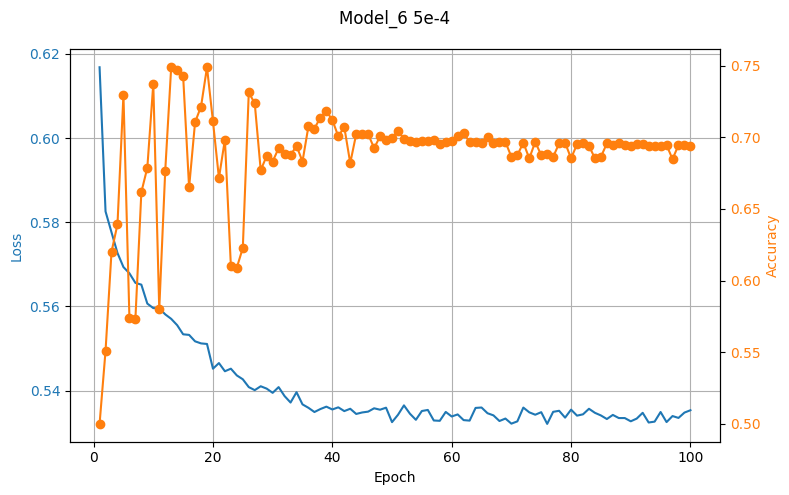


Model to test: Model_6 2e-3
feature_dim: 2048
lr=0.002 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 18/100 loss=0.5689 val_acc=0.5548 best=0.6442:  18%|▏| 18/100 [34:23<2:35:

Epoch 00018: reducing learning rate of group 0 to 1.0000e-03.


Epoch 24/100 loss=0.5609 val_acc=0.5685 best=0.6442:  24%|▏| 24/100 [45:41<2:23:

Epoch 00024: reducing learning rate of group 0 to 5.0000e-04.


Epoch 30/100 loss=0.5564 val_acc=0.5932 best=0.6442:  30%|▎| 30/100 [57:11<2:13:

Epoch 00030: reducing learning rate of group 0 to 2.5000e-04.


Epoch 36/100 loss=0.5541 val_acc=0.6179 best=0.6442:  36%|▎| 36/100 [1:08:27<2:0

Epoch 00036: reducing learning rate of group 0 to 1.2500e-04.


Epoch 42/100 loss=0.5504 val_acc=0.6058 best=0.6442:  42%|▍| 42/100 [1:19:52<1:5

Epoch 00042: reducing learning rate of group 0 to 6.2500e-05.


Epoch 48/100 loss=0.5490 val_acc=0.6086 best=0.6442:  48%|▍| 48/100 [1:31:10<1:3

Epoch 00048: reducing learning rate of group 0 to 3.1250e-05.


Epoch 54/100 loss=0.5488 val_acc=0.6113 best=0.6442:  54%|▌| 54/100 [1:42:29<1:2

Epoch 00054: reducing learning rate of group 0 to 1.5625e-05.


Epoch 60/100 loss=0.5500 val_acc=0.6217 best=0.6442:  60%|▌| 60/100 [1:53:54<1:1

Epoch 00060: reducing learning rate of group 0 to 7.8125e-06.


Epoch 66/100 loss=0.5486 val_acc=0.6173 best=0.6442:  66%|▋| 66/100 [2:05:24<1:0

Epoch 00066: reducing learning rate of group 0 to 3.9063e-06.


Epoch 72/100 loss=0.5477 val_acc=0.6146 best=0.6442:  72%|▋| 72/100 [2:16:40<53:

Epoch 00072: reducing learning rate of group 0 to 1.9531e-06.


Epoch 78/100 loss=0.5475 val_acc=0.6190 best=0.6442:  78%|▊| 78/100 [2:28:09<41:

Epoch 00078: reducing learning rate of group 0 to 9.7656e-07.


Epoch 84/100 loss=0.5484 val_acc=0.6195 best=0.6442:  84%|▊| 84/100 [2:39:22<29:

Epoch 00084: reducing learning rate of group 0 to 4.8828e-07.


Epoch 90/100 loss=0.5484 val_acc=0.6075 best=0.6442:  90%|▉| 90/100 [2:50:47<18:

Epoch 00090: reducing learning rate of group 0 to 2.4414e-07.


Epoch 96/100 loss=0.5492 val_acc=0.6201 best=0.6442:  96%|▉| 96/100 [3:02:07<07:

Epoch 00096: reducing learning rate of group 0 to 1.2207e-07.


Epoch 100/100 loss=0.5496 val_acc=0.6201 best=0.6442: 100%|█| 100/100 [3:09:45<0

Best val accuracy: 0.6441885964912281


Final TEST accuracy: 0.6534653465346535


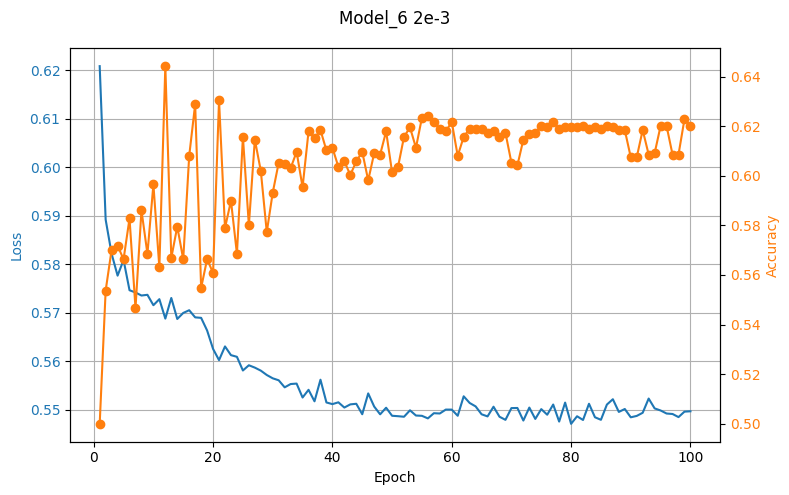


Model to test: Model_19 1e-3
feature_dim: 1536
lr=0.001 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 9/100 loss=0.5593 val_acc=0.6848 best=0.7451:   9%| | 9/100 [12:47<2:08:12

Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/100 loss=0.5430 val_acc=0.6897 best=0.7648:  21%|▏| 21/100 [29:56<1:52:

Epoch 00021: reducing learning rate of group 0 to 2.5000e-04.


Epoch 31/100 loss=0.5340 val_acc=0.7456 best=0.7675:  31%|▎| 31/100 [44:07<1:38:

Epoch 00031: reducing learning rate of group 0 to 1.2500e-04.


Epoch 44/100 loss=0.5274 val_acc=0.7747 best=0.7851:  44%|▍| 44/100 [1:02:38<1:1

Epoch 00044: reducing learning rate of group 0 to 6.2500e-05.


Epoch 51/100 loss=0.5232 val_acc=0.7774 best=0.7911:  51%|▌| 51/100 [1:12:42<1:1

Epoch 00051: reducing learning rate of group 0 to 3.1250e-05.


Epoch 58/100 loss=0.5202 val_acc=0.7823 best=0.7917:  58%|▌| 58/100 [1:22:50<1:0

Epoch 00058: reducing learning rate of group 0 to 1.5625e-05.


Epoch 64/100 loss=0.5192 val_acc=0.7906 best=0.7917:  64%|▋| 64/100 [1:31:32<52:

Epoch 00064: reducing learning rate of group 0 to 7.8125e-06.


Epoch 70/100 loss=0.5168 val_acc=0.7906 best=0.7917:  70%|▋| 70/100 [1:40:12<43:

Epoch 00070: reducing learning rate of group 0 to 3.9063e-06.


Epoch 78/100 loss=0.5176 val_acc=0.7900 best=0.7944:  78%|▊| 78/100 [1:51:37<31:

Epoch 00078: reducing learning rate of group 0 to 1.9531e-06.


Epoch 84/100 loss=0.5190 val_acc=0.7917 best=0.7944:  84%|▊| 84/100 [2:00:21<23:

Epoch 00084: reducing learning rate of group 0 to 9.7656e-07.


Epoch 90/100 loss=0.5178 val_acc=0.7884 best=0.7944:  90%|▉| 90/100 [2:09:01<14:

Epoch 00090: reducing learning rate of group 0 to 4.8828e-07.


Epoch 96/100 loss=0.5174 val_acc=0.7884 best=0.7944:  96%|▉| 96/100 [2:17:44<05:

Epoch 00096: reducing learning rate of group 0 to 2.4414e-07.


Epoch 100/100 loss=0.5170 val_acc=0.7873 best=0.7944: 100%|█| 100/100 [2:23:28<0

Best val accuracy: 0.7944078947368421


Final TEST accuracy: 0.7953795379537953


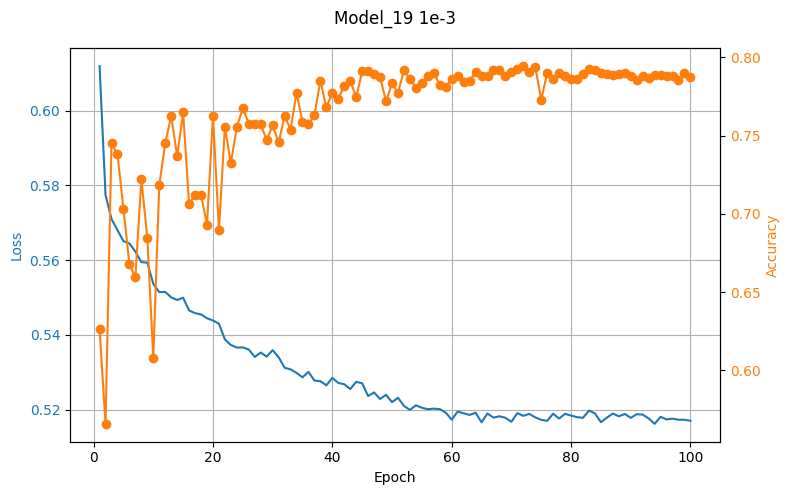

Model to test: Model_19 1e-3
feature_dim: 1536
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x787b31d940a0>


Epoch 20/100 loss=0.5523 val_acc=0.6464 best=0.7456:  20%|▏| 20/100 [29:13<1:57:

Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.


Epoch 28/100 loss=0.5438 val_acc=0.7511 best=0.7664:  28%|▎| 28/100 [41:04<1:45:

Epoch 00028: reducing learning rate of group 0 to 2.5000e-04.


Epoch 34/100 loss=0.5403 val_acc=0.7610 best=0.7664:  34%|▎| 34/100 [49:49<1:36:

Epoch 00034: reducing learning rate of group 0 to 1.2500e-04.


Epoch 42/100 loss=0.5353 val_acc=0.6930 best=0.7686:  42%|▍| 42/100 [1:01:37<1:2

Epoch 00042: reducing learning rate of group 0 to 6.2500e-05.


Epoch 52/100 loss=0.5359 val_acc=0.7045 best=0.7730:  52%|▌| 52/100 [1:16:18<1:1

Epoch 00052: reducing learning rate of group 0 to 3.1250e-05.


Epoch 58/100 loss=0.5344 val_acc=0.7341 best=0.7730:  58%|▌| 58/100 [1:25:12<1:0

Epoch 00058: reducing learning rate of group 0 to 1.5625e-05.


Epoch 64/100 loss=0.5343 val_acc=0.7418 best=0.7730:  64%|▋| 64/100 [1:34:04<53:

Epoch 00064: reducing learning rate of group 0 to 7.8125e-06.


Epoch 70/100 loss=0.5327 val_acc=0.7072 best=0.7730:  70%|▋| 70/100 [1:42:39<43:

Epoch 00070: reducing learning rate of group 0 to 3.9063e-06.


Epoch 76/100 loss=0.5339 val_acc=0.7072 best=0.7730:  76%|▊| 76/100 [1:51:18<34:

Epoch 00076: reducing learning rate of group 0 to 1.9531e-06.


Epoch 82/100 loss=0.5333 val_acc=0.7067 best=0.7730:  82%|▊| 82/100 [2:00:06<26:

Epoch 00082: reducing learning rate of group 0 to 9.7656e-07.


Epoch 88/100 loss=0.5327 val_acc=0.7023 best=0.7730:  88%|▉| 88/100 [2:08:44<17:

Epoch 00088: reducing learning rate of group 0 to 4.8828e-07.


Epoch 94/100 loss=0.5328 val_acc=0.7034 best=0.7730:  94%|▉| 94/100 [2:17:35<08:

Epoch 00094: reducing learning rate of group 0 to 2.4414e-07.


Epoch 100/100 loss=0.5330 val_acc=0.7056 best=0.7730: 100%|█| 100/100 [2:26:29<0

Epoch 00100: reducing learning rate of group 0 to 1.2207e-07.
Best val accuracy: 0.7730263157894737


Final TEST accuracy: 0.7799779977997799


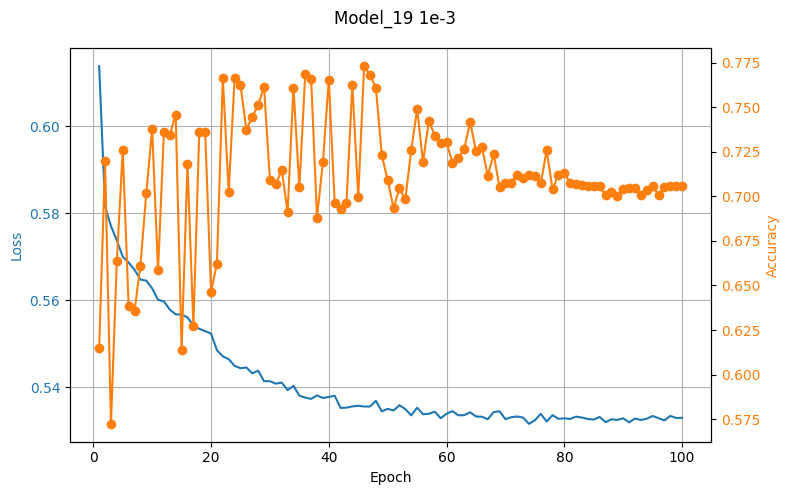


Model to test: Model_19 3e-4
feature_dim: 1536
lr=0.0003 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 14/100 loss=0.5532 val_acc=0.6557 best=0.7412:  14%|▏| 14/100 [20:34<2:04:

Epoch 00014: reducing learning rate of group 0 to 1.5000e-04.


Epoch 20/100 loss=0.5448 val_acc=0.6409 best=0.7412:  20%|▏| 20/100 [29:24<1:56:

Epoch 00020: reducing learning rate of group 0 to 7.5000e-05.


Epoch 26/100 loss=0.5399 val_acc=0.6924 best=0.7412:  26%|▎| 26/100 [38:15<1:49:

Epoch 00026: reducing learning rate of group 0 to 3.7500e-05.


Epoch 32/100 loss=0.5382 val_acc=0.6924 best=0.7412:  32%|▎| 32/100 [46:58<1:37:

Epoch 00032: reducing learning rate of group 0 to 1.8750e-05.


Epoch 38/100 loss=0.5367 val_acc=0.6831 best=0.7412:  38%|▍| 38/100 [55:47<1:30:

Epoch 00038: reducing learning rate of group 0 to 9.3750e-06.


Epoch 44/100 loss=0.5354 val_acc=0.7116 best=0.7412:  44%|▍| 44/100 [1:04:34<1:2

Epoch 00044: reducing learning rate of group 0 to 4.6875e-06.


Epoch 50/100 loss=0.5348 val_acc=0.7007 best=0.7412:  50%|▌| 50/100 [1:13:17<1:1

Epoch 00050: reducing learning rate of group 0 to 2.3437e-06.


Epoch 56/100 loss=0.5337 val_acc=0.7226 best=0.7412:  56%|▌| 56/100 [1:22:01<1:0

Epoch 00056: reducing learning rate of group 0 to 1.1719e-06.


Epoch 62/100 loss=0.5346 val_acc=0.7182 best=0.7412:  62%|▌| 62/100 [1:30:50<55:

Epoch 00062: reducing learning rate of group 0 to 5.8594e-07.


Epoch 68/100 loss=0.5337 val_acc=0.7111 best=0.7412:  68%|▋| 68/100 [1:39:36<46:

Epoch 00068: reducing learning rate of group 0 to 2.9297e-07.


Epoch 74/100 loss=0.5347 val_acc=0.7259 best=0.7412:  74%|▋| 74/100 [1:48:22<37:

Epoch 00074: reducing learning rate of group 0 to 1.4648e-07.


Epoch 80/100 loss=0.5348 val_acc=0.7144 best=0.7412:  80%|▊| 80/100 [1:57:14<29:

Epoch 00080: reducing learning rate of group 0 to 7.3242e-08.


Epoch 86/100 loss=0.5336 val_acc=0.7138 best=0.7412:  86%|▊| 86/100 [2:06:06<20:

Epoch 00086: reducing learning rate of group 0 to 3.6621e-08.


Epoch 92/100 loss=0.5345 val_acc=0.7155 best=0.7412:  92%|▉| 92/100 [2:14:56<11:

Epoch 00092: reducing learning rate of group 0 to 1.8311e-08.


Epoch 100/100 loss=0.5335 val_acc=0.7149 best=0.7412: 100%|█| 100/100 [2:26:39<0

Best val accuracy: 0.7412280701754386


Final TEST accuracy: 0.7414741474147415


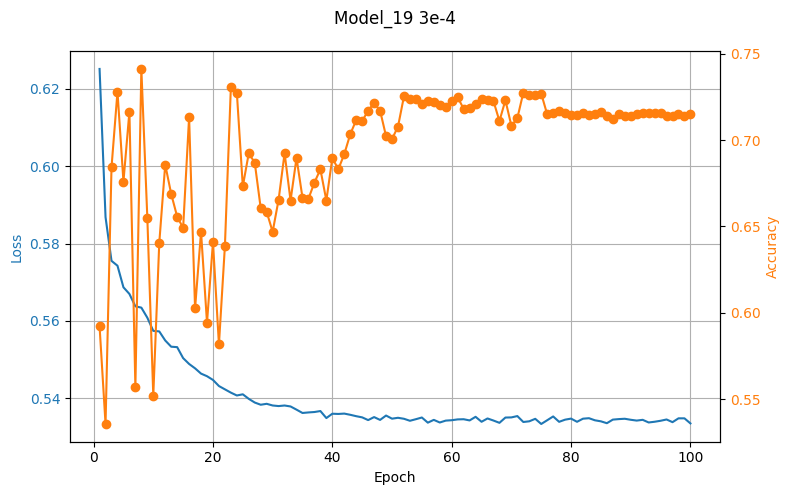


Model to test: Model_19 5e-4
feature_dim: 1536
lr=0.0005 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 14/100 loss=0.5501 val_acc=0.6212 best=0.7396:  14%|▏| 14/100 [20:24<2:05:

Epoch 00014: reducing learning rate of group 0 to 2.5000e-04.


Epoch 20/100 loss=0.5431 val_acc=0.6700 best=0.7396:  20%|▏| 20/100 [28:57<1:53:

Epoch 00020: reducing learning rate of group 0 to 1.2500e-04.


Epoch 26/100 loss=0.5373 val_acc=0.6700 best=0.7396:  26%|▎| 26/100 [36:44<1:37:

Epoch 00026: reducing learning rate of group 0 to 6.2500e-05.


Epoch 32/100 loss=0.5346 val_acc=0.6436 best=0.7396:  32%|▎| 32/100 [44:30<1:27:

Epoch 00032: reducing learning rate of group 0 to 3.1250e-05.


Epoch 38/100 loss=0.5329 val_acc=0.6820 best=0.7396:  38%|▍| 38/100 [52:16<1:20:

Epoch 00038: reducing learning rate of group 0 to 1.5625e-05.


Epoch 44/100 loss=0.5317 val_acc=0.6376 best=0.7396:  44%|▍| 44/100 [1:00:00<1:1

Epoch 00044: reducing learning rate of group 0 to 7.8125e-06.


Epoch 50/100 loss=0.5311 val_acc=0.6502 best=0.7396:  50%|▌| 50/100 [1:07:55<1:0

Epoch 00050: reducing learning rate of group 0 to 3.9063e-06.


Epoch 56/100 loss=0.5311 val_acc=0.6804 best=0.7396:  56%|▌| 56/100 [1:15:47<57:

Epoch 00056: reducing learning rate of group 0 to 1.9531e-06.


Epoch 62/100 loss=0.5308 val_acc=0.6842 best=0.7396:  62%|▌| 62/100 [1:24:04<53:

Epoch 00062: reducing learning rate of group 0 to 9.7656e-07.


Epoch 68/100 loss=0.5304 val_acc=0.6837 best=0.7396:  68%|▋| 68/100 [1:32:29<43:

Epoch 00068: reducing learning rate of group 0 to 4.8828e-07.


Epoch 74/100 loss=0.5306 val_acc=0.6837 best=0.7396:  74%|▋| 74/100 [1:41:30<38:

Epoch 00074: reducing learning rate of group 0 to 2.4414e-07.


Epoch 80/100 loss=0.5304 val_acc=0.6809 best=0.7396:  80%|▊| 80/100 [1:50:35<30:

Epoch 00080: reducing learning rate of group 0 to 1.2207e-07.


Epoch 86/100 loss=0.5297 val_acc=0.6842 best=0.7396:  86%|▊| 86/100 [1:59:44<21:

Epoch 00086: reducing learning rate of group 0 to 6.1035e-08.


Epoch 92/100 loss=0.5305 val_acc=0.6831 best=0.7396:  92%|▉| 92/100 [2:08:44<12:

Epoch 00092: reducing learning rate of group 0 to 3.0518e-08.


Epoch 98/100 loss=0.5296 val_acc=0.6842 best=0.7396:  98%|▉| 98/100 [2:17:55<03:

Epoch 00098: reducing learning rate of group 0 to 1.5259e-08.


Epoch 100/100 loss=0.5305 val_acc=0.6837 best=0.7396: 100%|█| 100/100 [2:20:58<0

Best val accuracy: 0.7395833333333334


Final TEST accuracy: 0.7491749174917491


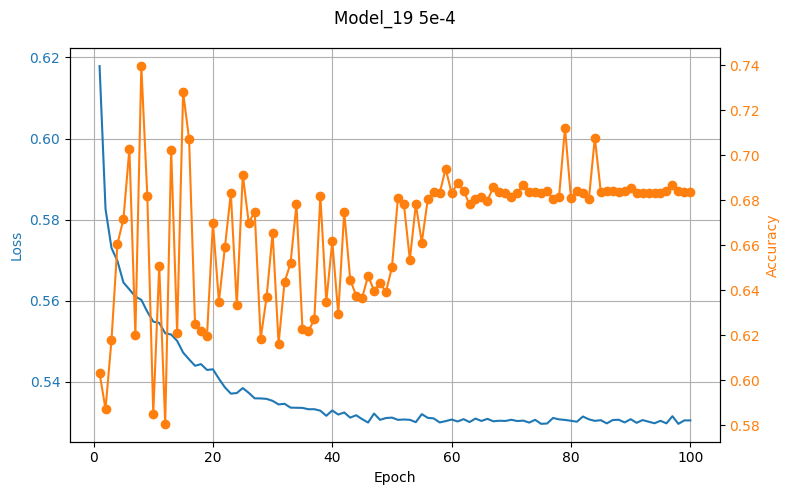


Model to test: Model_19 2e-3
feature_dim: 1536
lr=0.002 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 7/100 loss=0.5691 val_acc=0.5746 best=0.5970:   7%| | 7/100 [10:47<2:21:23

Epoch 00007: reducing learning rate of group 0 to 1.0000e-03.


Epoch 26/100 loss=0.5434 val_acc=0.7730 best=0.7939:  26%|▎| 26/100 [40:01<1:54:

Epoch 00026: reducing learning rate of group 0 to 5.0000e-04.


Epoch 32/100 loss=0.5331 val_acc=0.7785 best=0.7939:  32%|▎| 32/100 [49:04<1:43:

Epoch 00032: reducing learning rate of group 0 to 2.5000e-04.


Epoch 44/100 loss=0.5297 val_acc=0.7834 best=0.8136:  44%|▍| 44/100 [1:07:31<1:2

Epoch 00044: reducing learning rate of group 0 to 1.2500e-04.


Epoch 50/100 loss=0.5254 val_acc=0.7878 best=0.8136:  50%|▌| 50/100 [1:16:35<1:1

Epoch 00050: reducing learning rate of group 0 to 6.2500e-05.


Epoch 56/100 loss=0.5204 val_acc=0.7884 best=0.8136:  56%|▌| 56/100 [1:25:02<1:0

Epoch 00056: reducing learning rate of group 0 to 3.1250e-05.


Epoch 62/100 loss=0.5217 val_acc=0.8081 best=0.8136:  62%|▌| 62/100 [1:33:37<54:

Epoch 00062: reducing learning rate of group 0 to 1.5625e-05.


Epoch 68/100 loss=0.5192 val_acc=0.7961 best=0.8136:  68%|▋| 68/100 [1:42:50<48:

Epoch 00068: reducing learning rate of group 0 to 7.8125e-06.


Epoch 74/100 loss=0.5203 val_acc=0.8037 best=0.8136:  74%|▋| 74/100 [1:52:01<39:

Epoch 00074: reducing learning rate of group 0 to 3.9063e-06.


Epoch 80/100 loss=0.5204 val_acc=0.8092 best=0.8136:  80%|▊| 80/100 [2:01:10<30:

Epoch 00080: reducing learning rate of group 0 to 1.9531e-06.


Epoch 86/100 loss=0.5195 val_acc=0.8098 best=0.8136:  86%|▊| 86/100 [2:10:18<21:

Epoch 00086: reducing learning rate of group 0 to 9.7656e-07.


Epoch 92/100 loss=0.5201 val_acc=0.8098 best=0.8136:  92%|▉| 92/100 [2:19:30<12:

Epoch 00092: reducing learning rate of group 0 to 4.8828e-07.


Epoch 98/100 loss=0.5199 val_acc=0.8021 best=0.8136:  98%|▉| 98/100 [2:28:40<03:

Epoch 00098: reducing learning rate of group 0 to 2.4414e-07.


Epoch 100/100 loss=0.5181 val_acc=0.8026 best=0.8136: 100%|█| 100/100 [2:31:45<0

Best val accuracy: 0.8135964912280702


Final TEST accuracy: 0.8074807480748075


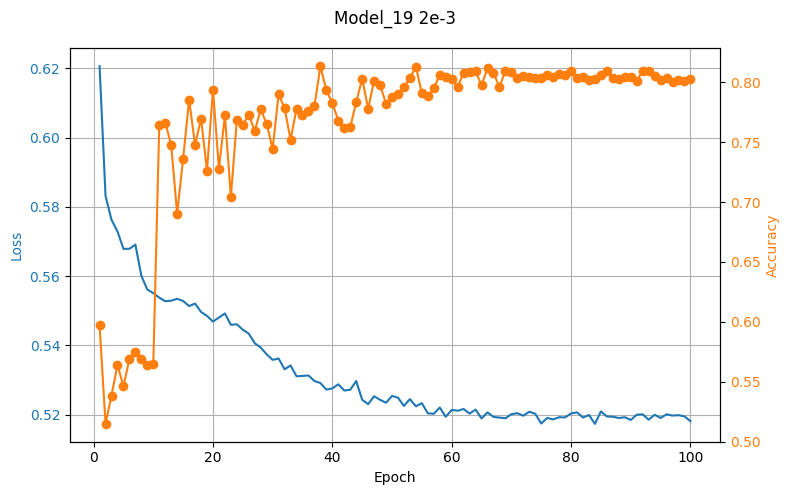


Model to test: M13_3_Extra1x1Late 1e-3
feature_dim: 16384
lr=0.001 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 17/100 loss=0.5507 val_acc=0.6398 best=0.6606:  17%|▏| 17/100 [41:05<3:19:

Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


Epoch 25/100 loss=0.5399 val_acc=0.6288 best=0.6765:  25%|▎| 25/100 [1:00:18<2:5

Epoch 00025: reducing learning rate of group 0 to 2.5000e-04.


Epoch 31/100 loss=0.5354 val_acc=0.6118 best=0.6765:  31%|▎| 31/100 [1:14:41<2:4

Epoch 00031: reducing learning rate of group 0 to 1.2500e-04.


Epoch 37/100 loss=0.5330 val_acc=0.6190 best=0.6765:  37%|▎| 37/100 [1:29:10<2:3

Epoch 00037: reducing learning rate of group 0 to 6.2500e-05.


Epoch 48/100 loss=0.5300 val_acc=0.7955 best=0.8026:  48%|▍| 48/100 [1:55:45<2:0

Epoch 00048: reducing learning rate of group 0 to 3.1250e-05.


Epoch 63/100 loss=0.5275 val_acc=0.7933 best=0.8109:  63%|▋| 63/100 [2:30:44<1:2

Epoch 00063: reducing learning rate of group 0 to 1.5625e-05.


Epoch 69/100 loss=0.5261 val_acc=0.7928 best=0.8109:  69%|▋| 69/100 [2:46:31<1:2

Epoch 00069: reducing learning rate of group 0 to 7.8125e-06.


Epoch 75/100 loss=0.5263 val_acc=0.7889 best=0.8109:  75%|▊| 75/100 [2:59:54<57:

Epoch 00075: reducing learning rate of group 0 to 3.9063e-06.


Epoch 81/100 loss=0.5256 val_acc=0.7928 best=0.8109:  81%|▊| 81/100 [3:13:42<43:

Epoch 00081: reducing learning rate of group 0 to 1.9531e-06.


Epoch 87/100 loss=0.5262 val_acc=0.7971 best=0.8109:  87%|▊| 87/100 [3:27:30<29:

Epoch 00087: reducing learning rate of group 0 to 9.7656e-07.


Epoch 93/100 loss=0.5249 val_acc=0.7944 best=0.8109:  93%|▉| 93/100 [3:41:14<16:

Epoch 00093: reducing learning rate of group 0 to 4.8828e-07.


Epoch 99/100 loss=0.5255 val_acc=0.7944 best=0.8109:  99%|▉| 99/100 [3:55:45<02:

Epoch 00099: reducing learning rate of group 0 to 2.4414e-07.


Epoch 100/100 loss=0.5243 val_acc=0.7922 best=0.8109: 100%|█| 100/100 [3:58:09<0

Best val accuracy: 0.8108552631578947


Final TEST accuracy: 0.7942794279427943


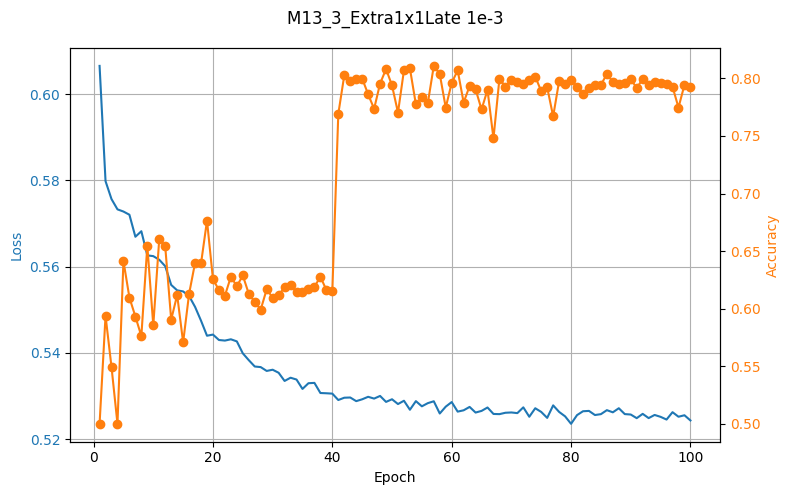

Model to test: M13_3_Extra1x1Late 1e-3
feature_dim: 16384
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x787b31b94220>


Epoch 26/100 loss=0.5431 val_acc=0.6096 best=0.7889:  26%|▎| 26/100 [1:03:23<2:5

Epoch 00026: reducing learning rate of group 0 to 5.0000e-04.


Epoch 32/100 loss=0.5361 val_acc=0.6206 best=0.7889:  32%|▎| 32/100 [1:17:58<2:4

Epoch 00032: reducing learning rate of group 0 to 2.5000e-04.


Epoch 38/100 loss=0.5289 val_acc=0.6250 best=0.7889:  38%|▍| 38/100 [1:32:35<2:3

Epoch 00038: reducing learning rate of group 0 to 1.2500e-04.


Epoch 44/100 loss=0.5251 val_acc=0.6053 best=0.7889:  44%|▍| 44/100 [1:47:10<2:1

Epoch 00044: reducing learning rate of group 0 to 6.2500e-05.


Epoch 71/100 loss=0.5177 val_acc=0.7988 best=0.8218:  71%|▋| 71/100 [2:52:51<1:1

Epoch 00071: reducing learning rate of group 0 to 3.1250e-05.


Epoch 77/100 loss=0.5160 val_acc=0.8147 best=0.8218:  77%|▊| 77/100 [3:07:24<55:

Epoch 00077: reducing learning rate of group 0 to 1.5625e-05.


Epoch 83/100 loss=0.5148 val_acc=0.8103 best=0.8218:  83%|▊| 83/100 [3:21:58<41:

Epoch 00083: reducing learning rate of group 0 to 7.8125e-06.


Epoch 89/100 loss=0.5143 val_acc=0.8092 best=0.8218:  89%|▉| 89/100 [3:36:33<26:

Epoch 00089: reducing learning rate of group 0 to 3.9063e-06.


Epoch 95/100 loss=0.5150 val_acc=0.8081 best=0.8218:  95%|▉| 95/100 [3:51:23<12:

Epoch 00095: reducing learning rate of group 0 to 1.9531e-06.


Epoch 100/100 loss=0.5135 val_acc=0.8026 best=0.8218: 100%|█| 100/100 [4:03:56<0

Best val accuracy: 0.8218201754385965


Final TEST accuracy: 0.8162816281628162


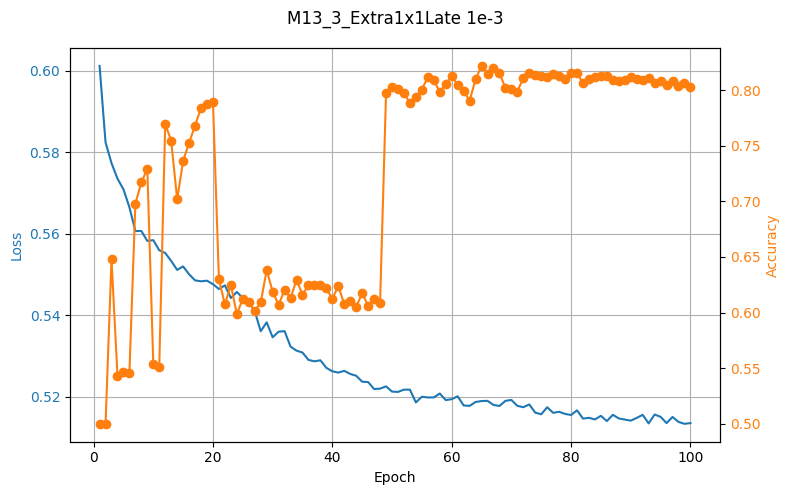


Model to test: M13_3_Extra1x1Late 3e-4
feature_dim: 16384
lr=0.0003 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 35/100 loss=0.5326 val_acc=0.7845 best=0.8191:  35%|▎| 35/100 [1:31:18<2:5

Epoch 00035: reducing learning rate of group 0 to 1.5000e-04.


Epoch 41/100 loss=0.5220 val_acc=0.7308 best=0.8191:  41%|▍| 41/100 [1:48:20<2:4

Epoch 00041: reducing learning rate of group 0 to 7.5000e-05.


Epoch 47/100 loss=0.5153 val_acc=0.7264 best=0.8191:  47%|▍| 47/100 [2:02:26<2:0

Epoch 00047: reducing learning rate of group 0 to 3.7500e-05.


Epoch 53/100 loss=0.5101 val_acc=0.7555 best=0.8191:  53%|▌| 53/100 [2:16:27<1:5

Epoch 00053: reducing learning rate of group 0 to 1.8750e-05.


Epoch 59/100 loss=0.5084 val_acc=0.7407 best=0.8191:  59%|▌| 59/100 [2:31:13<1:4

Epoch 00059: reducing learning rate of group 0 to 9.3750e-06.


Epoch 65/100 loss=0.5079 val_acc=0.7368 best=0.8191:  65%|▋| 65/100 [2:45:50<1:2

Epoch 00065: reducing learning rate of group 0 to 4.6875e-06.


Epoch 71/100 loss=0.5068 val_acc=0.7511 best=0.8191:  71%|▋| 71/100 [3:00:29<1:1

Epoch 00071: reducing learning rate of group 0 to 2.3437e-06.


Epoch 77/100 loss=0.5072 val_acc=0.7440 best=0.8191:  77%|▊| 77/100 [3:15:16<56:

Epoch 00077: reducing learning rate of group 0 to 1.1719e-06.


Epoch 83/100 loss=0.5060 val_acc=0.7423 best=0.8191:  83%|▊| 83/100 [3:29:46<41:

Epoch 00083: reducing learning rate of group 0 to 5.8594e-07.


Epoch 89/100 loss=0.5057 val_acc=0.7451 best=0.8191:  89%|▉| 89/100 [3:44:20<26:

Epoch 00089: reducing learning rate of group 0 to 2.9297e-07.


Epoch 95/100 loss=0.5062 val_acc=0.7451 best=0.8191:  95%|▉| 95/100 [3:58:59<12:

Epoch 00095: reducing learning rate of group 0 to 1.4648e-07.


Epoch 100/100 loss=0.5067 val_acc=0.7440 best=0.8191: 100%|█| 100/100 [4:11:12<0

Best val accuracy: 0.819078947368421


Final TEST accuracy: 0.8184818481848185


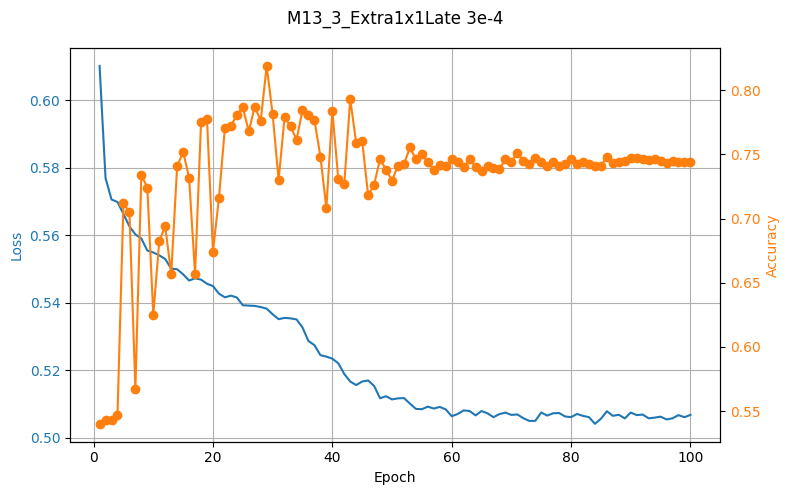


Model to test: M13_3_Extra1x1Late 5e-4
feature_dim: 16384
lr=0.0005 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 45/100 loss=0.5334 val_acc=0.8251 best=0.8350:  45%|▍| 45/100 [1:49:24<2:1

Epoch 00045: reducing learning rate of group 0 to 2.5000e-04.


Epoch 58/100 loss=0.5258 val_acc=0.7692 best=0.8492:  58%|▌| 58/100 [2:20:57<1:4

Epoch 00058: reducing learning rate of group 0 to 1.2500e-04.


Epoch 64/100 loss=0.5199 val_acc=0.8120 best=0.8492:  64%|▋| 64/100 [2:35:36<1:2

Epoch 00064: reducing learning rate of group 0 to 6.2500e-05.


Epoch 70/100 loss=0.5176 val_acc=0.8032 best=0.8492:  70%|▋| 70/100 [2:50:09<1:1

Epoch 00070: reducing learning rate of group 0 to 3.1250e-05.


Epoch 76/100 loss=0.5150 val_acc=0.8235 best=0.8492:  76%|▊| 76/100 [3:04:47<58:

Epoch 00076: reducing learning rate of group 0 to 1.5625e-05.


Epoch 82/100 loss=0.5153 val_acc=0.8279 best=0.8492:  82%|▊| 82/100 [3:19:23<43:

Epoch 00082: reducing learning rate of group 0 to 7.8125e-06.


Epoch 88/100 loss=0.5133 val_acc=0.8229 best=0.8492:  88%|▉| 88/100 [3:31:37<26:

Epoch 00088: reducing learning rate of group 0 to 3.9063e-06.


Epoch 94/100 loss=0.5137 val_acc=0.8295 best=0.8492:  94%|▉| 94/100 [3:44:34<13:

Epoch 00094: reducing learning rate of group 0 to 1.9531e-06.


Epoch 100/100 loss=0.5127 val_acc=0.8273 best=0.8492: 100%|█| 100/100 [3:59:54<0

Epoch 00100: reducing learning rate of group 0 to 9.7656e-07.
Best val accuracy: 0.8492324561403509


Final TEST accuracy: 0.8536853685368537


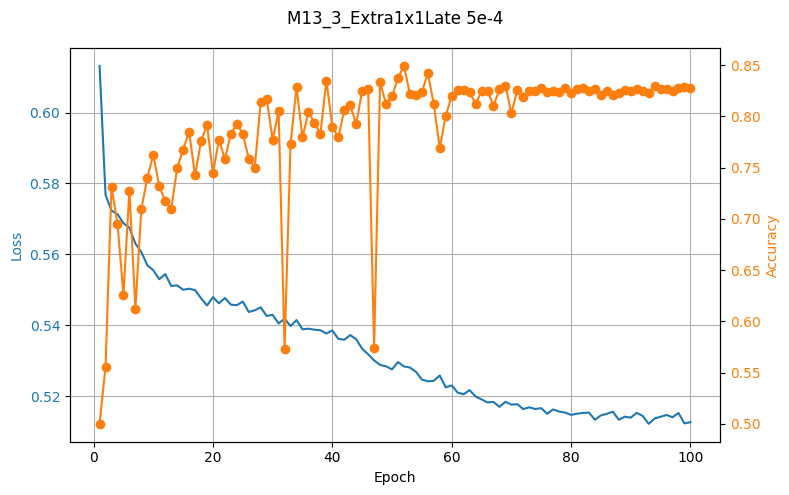


Model to test: M13_3_Extra1x1Late 2e-3
feature_dim: 16384
lr=0.002 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 17/100 loss=0.5692 val_acc=0.6135 best=0.7500:  17%|▏| 17/100 [43:28<3:31:

Epoch 00017: reducing learning rate of group 0 to 1.0000e-03.


Epoch 31/100 loss=0.5430 val_acc=0.7511 best=0.7928:  31%|▎| 31/100 [1:18:59<2:5

Epoch 00031: reducing learning rate of group 0 to 5.0000e-04.


Epoch 38/100 loss=0.5369 val_acc=0.7659 best=0.7955:  38%|▍| 38/100 [1:36:36<2:3

Epoch 00038: reducing learning rate of group 0 to 2.5000e-04.


Epoch 44/100 loss=0.5345 val_acc=0.6228 best=0.7955:  44%|▍| 44/100 [1:51:48<2:2

Epoch 00044: reducing learning rate of group 0 to 1.2500e-04.


Epoch 50/100 loss=0.5280 val_acc=0.6179 best=0.7955:  50%|▌| 50/100 [2:06:59<2:0

Epoch 00050: reducing learning rate of group 0 to 6.2500e-05.


Epoch 56/100 loss=0.5298 val_acc=0.6425 best=0.7955:  56%|▌| 56/100 [2:22:17<1:5

Epoch 00056: reducing learning rate of group 0 to 3.1250e-05.


Epoch 62/100 loss=0.5240 val_acc=0.6239 best=0.7955:  62%|▌| 62/100 [2:37:32<1:3

Epoch 00062: reducing learning rate of group 0 to 1.5625e-05.


Epoch 68/100 loss=0.5260 val_acc=0.6365 best=0.7955:  68%|▋| 68/100 [2:52:50<1:2

Epoch 00068: reducing learning rate of group 0 to 7.8125e-06.


Epoch 74/100 loss=0.5262 val_acc=0.6414 best=0.7955:  74%|▋| 74/100 [3:08:07<1:0

Epoch 00074: reducing learning rate of group 0 to 3.9063e-06.


Epoch 80/100 loss=0.5235 val_acc=0.6239 best=0.7955:  80%|▊| 80/100 [3:23:26<51:

Epoch 00080: reducing learning rate of group 0 to 1.9531e-06.


Epoch 86/100 loss=0.5260 val_acc=0.6338 best=0.7955:  86%|▊| 86/100 [3:38:39<35:

Epoch 00086: reducing learning rate of group 0 to 9.7656e-07.


Epoch 92/100 loss=0.5244 val_acc=0.6310 best=0.7955:  92%|▉| 92/100 [3:53:56<20:

Epoch 00092: reducing learning rate of group 0 to 4.8828e-07.


Epoch 98/100 loss=0.5251 val_acc=0.6349 best=0.7955:  98%|▉| 98/100 [4:09:18<05:

Epoch 00098: reducing learning rate of group 0 to 2.4414e-07.


Epoch 100/100 loss=0.5236 val_acc=0.6305 best=0.7955: 100%|█| 100/100 [4:14:22<0

Best val accuracy: 0.7955043859649122


Final TEST accuracy: 0.7733773377337734


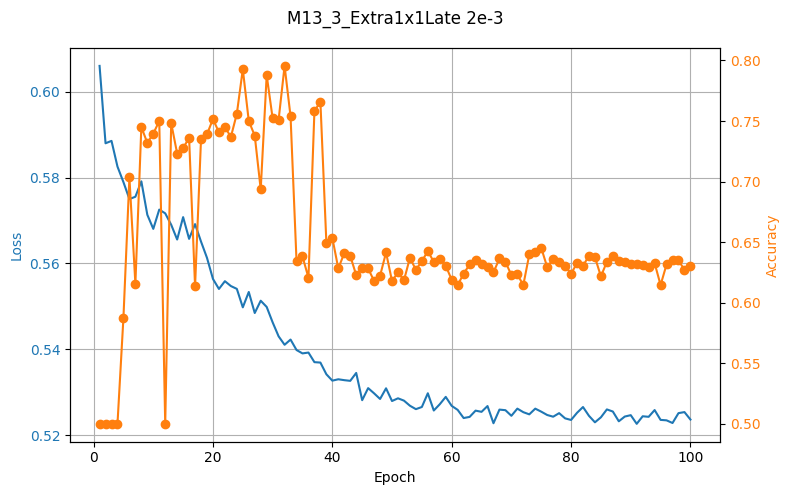


Model to test: M13_4_MorePoolBiggerFC 1e-3
feature_dim: 4096
lr=0.001 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 14/100 loss=0.5467 val_acc=0.6190 best=0.6672:  14%|▏| 14/100 [28:23<2:54:

Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Epoch 46/100 loss=0.5105 val_acc=0.7555 best=0.8048:  46%|▍| 46/100 [1:37:53<2:0

Epoch 00046: reducing learning rate of group 0 to 2.5000e-04.


Epoch 56/100 loss=0.5013 val_acc=0.7971 best=0.8213:  56%|▌| 56/100 [2:00:35<1:3

Epoch 00056: reducing learning rate of group 0 to 1.2500e-04.


Epoch 62/100 loss=0.4959 val_acc=0.7807 best=0.8213:  62%|▌| 62/100 [2:14:10<1:2

Epoch 00062: reducing learning rate of group 0 to 6.2500e-05.


Epoch 68/100 loss=0.4911 val_acc=0.8103 best=0.8213:  68%|▋| 68/100 [2:27:41<1:1

Epoch 00068: reducing learning rate of group 0 to 3.1250e-05.


Epoch 74/100 loss=0.4908 val_acc=0.8010 best=0.8213:  74%|▋| 74/100 [2:41:11<58:

Epoch 00074: reducing learning rate of group 0 to 1.5625e-05.


Epoch 80/100 loss=0.4882 val_acc=0.8185 best=0.8213:  80%|▊| 80/100 [2:54:44<45:

Epoch 00080: reducing learning rate of group 0 to 7.8125e-06.


Epoch 86/100 loss=0.4875 val_acc=0.8109 best=0.8213:  86%|▊| 86/100 [3:08:27<31:

Epoch 00086: reducing learning rate of group 0 to 3.9063e-06.


Epoch 92/100 loss=0.4863 val_acc=0.8125 best=0.8213:  92%|▉| 92/100 [3:22:01<18:

Epoch 00092: reducing learning rate of group 0 to 1.9531e-06.


Epoch 98/100 loss=0.4875 val_acc=0.8109 best=0.8213:  98%|▉| 98/100 [3:35:30<04:

Epoch 00098: reducing learning rate of group 0 to 9.7656e-07.


Epoch 100/100 loss=0.4868 val_acc=0.8070 best=0.8213: 100%|█| 100/100 [3:39:58<0

Best val accuracy: 0.8212719298245614


Final TEST accuracy: 0.8327832783278328


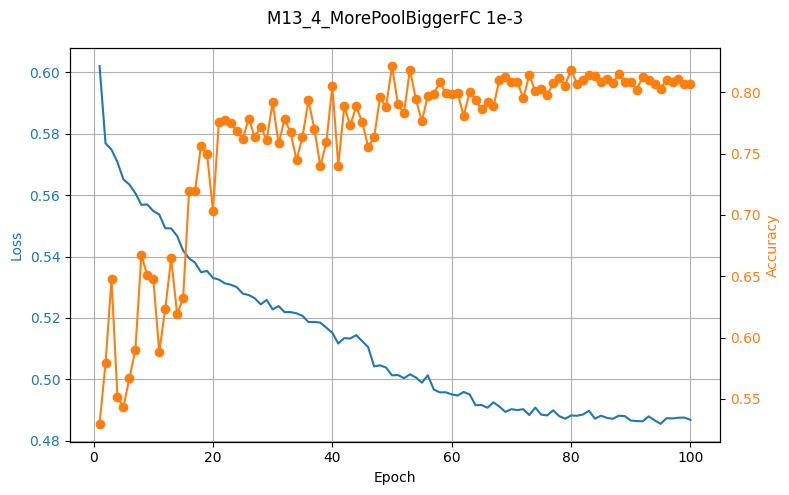

Model to test: M13_4_MorePoolBiggerFC 1e-3
feature_dim: 4096
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x787b31b3e980>


Epoch 8/100 loss=0.5620 val_acc=0.5532 best=0.6393:   8%| | 8/100 [18:18<3:28:40

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.


Epoch 19/100 loss=0.5449 val_acc=0.6058 best=0.7253:  19%|▏| 19/100 [43:16<3:04:

Epoch 00019: reducing learning rate of group 0 to 2.5000e-04.


Epoch 25/100 loss=0.5376 val_acc=0.7127 best=0.7253:  25%|▎| 25/100 [56:54<2:51:

Epoch 00025: reducing learning rate of group 0 to 1.2500e-04.


Epoch 31/100 loss=0.5314 val_acc=0.6645 best=0.7253:  31%|▎| 31/100 [1:10:34<2:3

Epoch 00031: reducing learning rate of group 0 to 6.2500e-05.


Epoch 37/100 loss=0.5300 val_acc=0.6623 best=0.7253:  37%|▎| 37/100 [1:24:05<2:2

Epoch 00037: reducing learning rate of group 0 to 3.1250e-05.


Epoch 43/100 loss=0.5278 val_acc=0.7050 best=0.7253:  43%|▍| 43/100 [1:37:42<2:0

Epoch 00043: reducing learning rate of group 0 to 1.5625e-05.


Epoch 49/100 loss=0.5265 val_acc=0.7209 best=0.7253:  49%|▍| 49/100 [1:51:17<1:5

Epoch 00049: reducing learning rate of group 0 to 7.8125e-06.


Epoch 57/100 loss=0.5258 val_acc=0.7166 best=0.7286:  57%|▌| 57/100 [2:09:24<1:3

Epoch 00057: reducing learning rate of group 0 to 3.9063e-06.


Epoch 63/100 loss=0.5258 val_acc=0.7127 best=0.7286:  63%|▋| 63/100 [2:22:57<1:2

Epoch 00063: reducing learning rate of group 0 to 1.9531e-06.


Epoch 69/100 loss=0.5261 val_acc=0.7226 best=0.7286:  69%|▋| 69/100 [2:36:29<1:0

Epoch 00069: reducing learning rate of group 0 to 9.7656e-07.


Epoch 75/100 loss=0.5259 val_acc=0.7198 best=0.7286:  75%|▊| 75/100 [2:50:05<56:

Epoch 00075: reducing learning rate of group 0 to 4.8828e-07.


Epoch 81/100 loss=0.5245 val_acc=0.7215 best=0.7286:  81%|▊| 81/100 [3:03:44<43:

Epoch 00081: reducing learning rate of group 0 to 2.4414e-07.


Epoch 87/100 loss=0.5254 val_acc=0.7177 best=0.7286:  87%|▊| 87/100 [3:17:23<29:

Epoch 00087: reducing learning rate of group 0 to 1.2207e-07.


Epoch 93/100 loss=0.5253 val_acc=0.7171 best=0.7286:  93%|▉| 93/100 [3:31:02<15:

Epoch 00093: reducing learning rate of group 0 to 6.1035e-08.


Epoch 99/100 loss=0.5254 val_acc=0.7198 best=0.7286:  99%|▉| 99/100 [3:44:43<02:

Epoch 00099: reducing learning rate of group 0 to 3.0518e-08.


Epoch 100/100 loss=0.5258 val_acc=0.7198 best=0.7286: 100%|█| 100/100 [3:47:00<0

Best val accuracy: 0.7286184210526315


Final TEST accuracy: 0.7381738173817382


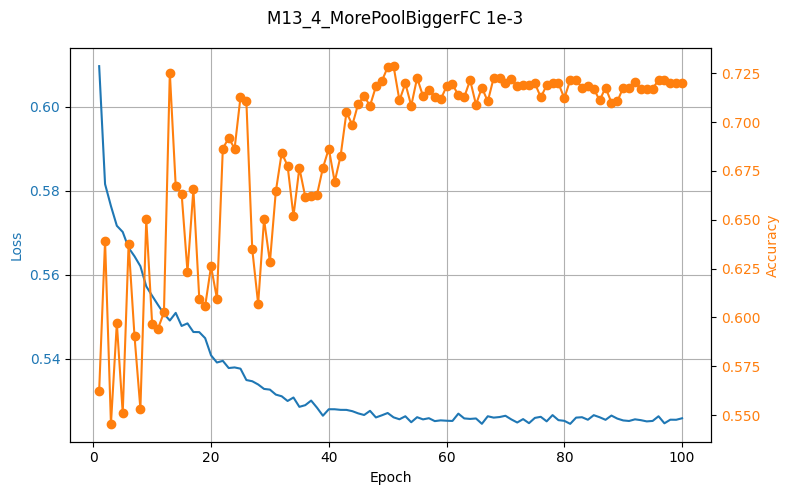


Model to test: M13_4_MorePoolBiggerFC 3e-4
feature_dim: 4096
lr=0.0003 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 9/100 loss=0.5539 val_acc=0.5241 best=0.7297:   9%| | 9/100 [20:22<3:21:53

Epoch 00009: reducing learning rate of group 0 to 1.5000e-04.


Epoch 19/100 loss=0.5366 val_acc=0.6875 best=0.7878:  19%|▏| 19/100 [42:45<2:59:

Epoch 00019: reducing learning rate of group 0 to 7.5000e-05.


Epoch 25/100 loss=0.5294 val_acc=0.6409 best=0.7878:  25%|▎| 25/100 [56:14<2:47:

Epoch 00025: reducing learning rate of group 0 to 3.7500e-05.


Epoch 31/100 loss=0.5268 val_acc=0.6634 best=0.7878:  31%|▎| 31/100 [1:09:40<2:3

Epoch 00031: reducing learning rate of group 0 to 1.8750e-05.


Epoch 37/100 loss=0.5233 val_acc=0.6842 best=0.7878:  37%|▎| 37/100 [1:23:12<2:2

Epoch 00037: reducing learning rate of group 0 to 9.3750e-06.


Epoch 43/100 loss=0.5207 val_acc=0.6787 best=0.7878:  43%|▍| 43/100 [1:36:41<2:0

Epoch 00043: reducing learning rate of group 0 to 4.6875e-06.


Epoch 49/100 loss=0.5200 val_acc=0.6985 best=0.7878:  49%|▍| 49/100 [1:49:28<1:4

Epoch 00049: reducing learning rate of group 0 to 2.3437e-06.


Epoch 55/100 loss=0.5201 val_acc=0.6902 best=0.7878:  55%|▌| 55/100 [2:02:16<1:3

Epoch 00055: reducing learning rate of group 0 to 1.1719e-06.


Epoch 61/100 loss=0.5181 val_acc=0.6891 best=0.7878:  61%|▌| 61/100 [2:15:53<1:2

Epoch 00061: reducing learning rate of group 0 to 5.8594e-07.


Epoch 67/100 loss=0.5191 val_acc=0.6880 best=0.7878:  67%|▋| 67/100 [2:29:24<1:1

Epoch 00067: reducing learning rate of group 0 to 2.9297e-07.


Epoch 73/100 loss=0.5200 val_acc=0.6853 best=0.7878:  73%|▋| 73/100 [2:43:00<1:0

Epoch 00073: reducing learning rate of group 0 to 1.4648e-07.


Epoch 79/100 loss=0.5191 val_acc=0.6870 best=0.7878:  79%|▊| 79/100 [2:56:35<47:

Epoch 00079: reducing learning rate of group 0 to 7.3242e-08.


Epoch 85/100 loss=0.5195 val_acc=0.6870 best=0.7878:  85%|▊| 85/100 [3:10:11<33:

Epoch 00085: reducing learning rate of group 0 to 3.6621e-08.


Epoch 91/100 loss=0.5191 val_acc=0.6880 best=0.7878:  91%|▉| 91/100 [3:23:46<20:

Epoch 00091: reducing learning rate of group 0 to 1.8311e-08.


Epoch 100/100 loss=0.5183 val_acc=0.6880 best=0.7878: 100%|█| 100/100 [3:44:01<0

Best val accuracy: 0.787828947368421


Final TEST accuracy: 0.7766776677667767


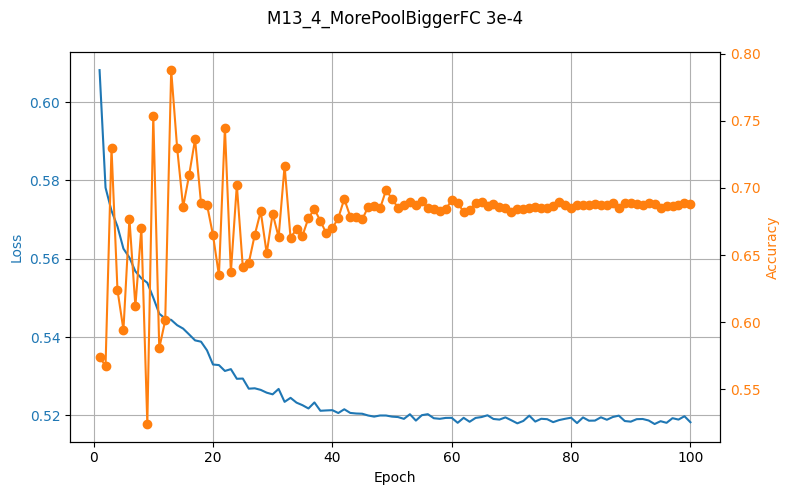


Model to test: M13_4_MorePoolBiggerFC 5e-4
feature_dim: 4096
lr=0.0005 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 9/100 loss=0.5534 val_acc=0.6294 best=0.7445:   9%| | 9/100 [20:38<3:26:27

Epoch 00009: reducing learning rate of group 0 to 2.5000e-04.


Epoch 15/100 loss=0.5381 val_acc=0.6064 best=0.7445:  15%|▏| 15/100 [34:07<3:11:

Epoch 00015: reducing learning rate of group 0 to 1.2500e-04.


Epoch 21/100 loss=0.5294 val_acc=0.6283 best=0.7445:  21%|▏| 21/100 [47:42<2:58:

Epoch 00021: reducing learning rate of group 0 to 6.2500e-05.


Epoch 27/100 loss=0.5245 val_acc=0.6283 best=0.7445:  27%|▎| 27/100 [1:01:20<2:4

Epoch 00027: reducing learning rate of group 0 to 3.1250e-05.


Epoch 38/100 loss=0.5183 val_acc=0.7697 best=0.7807:  38%|▍| 38/100 [1:26:16<2:2

Epoch 00038: reducing learning rate of group 0 to 1.5625e-05.


Epoch 44/100 loss=0.5173 val_acc=0.7736 best=0.7807:  44%|▍| 44/100 [1:39:52<2:0

Epoch 00044: reducing learning rate of group 0 to 7.8125e-06.


Epoch 50/100 loss=0.5163 val_acc=0.7763 best=0.7807:  50%|▌| 50/100 [1:53:24<1:5

Epoch 00050: reducing learning rate of group 0 to 3.9063e-06.


Epoch 56/100 loss=0.5170 val_acc=0.7730 best=0.7807:  56%|▌| 56/100 [2:06:51<1:3

Epoch 00056: reducing learning rate of group 0 to 1.9531e-06.


Epoch 62/100 loss=0.5151 val_acc=0.7719 best=0.7807:  62%|▌| 62/100 [2:19:39<1:2

Epoch 00062: reducing learning rate of group 0 to 9.7656e-07.


Epoch 68/100 loss=0.5151 val_acc=0.7769 best=0.7807:  68%|▋| 68/100 [2:32:38<1:1

Epoch 00068: reducing learning rate of group 0 to 4.8828e-07.


Epoch 74/100 loss=0.5149 val_acc=0.7763 best=0.7807:  74%|▋| 74/100 [2:46:15<59:

Epoch 00074: reducing learning rate of group 0 to 2.4414e-07.


Epoch 80/100 loss=0.5155 val_acc=0.7769 best=0.7807:  80%|▊| 80/100 [2:59:52<45:

Epoch 00080: reducing learning rate of group 0 to 1.2207e-07.


Epoch 86/100 loss=0.5156 val_acc=0.7774 best=0.7807:  86%|▊| 86/100 [3:13:33<31:

Epoch 00086: reducing learning rate of group 0 to 6.1035e-08.


Epoch 92/100 loss=0.5152 val_acc=0.7785 best=0.7807:  92%|▉| 92/100 [3:26:58<17:

Epoch 00092: reducing learning rate of group 0 to 3.0518e-08.


Epoch 98/100 loss=0.5152 val_acc=0.7785 best=0.7807:  98%|▉| 98/100 [3:40:34<04:

Epoch 00098: reducing learning rate of group 0 to 1.5259e-08.


Epoch 100/100 loss=0.5155 val_acc=0.7785 best=0.7807: 100%|█| 100/100 [3:45:09<0

Best val accuracy: 0.7807017543859649


Final TEST accuracy: 0.7711771177117712


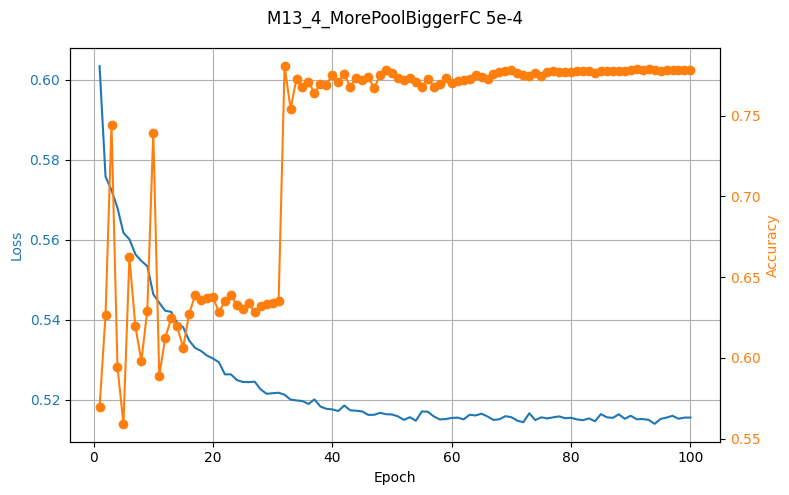


Model to test: M13_4_MorePoolBiggerFC 2e-3
feature_dim: 4096
lr=0.002 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 9/100 loss=0.5586 val_acc=0.5389 best=0.7045:   9%| | 9/100 [20:39<3:26:00

Epoch 00009: reducing learning rate of group 0 to 1.0000e-03.


Epoch 15/100 loss=0.5452 val_acc=0.6124 best=0.7045:  15%|▏| 15/100 [34:18<3:12:

Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Epoch 21/100 loss=0.5383 val_acc=0.6113 best=0.7045:  21%|▏| 21/100 [47:47<2:58:

Epoch 00021: reducing learning rate of group 0 to 2.5000e-04.


Epoch 27/100 loss=0.5337 val_acc=0.6075 best=0.7045:  27%|▎| 27/100 [1:01:12<2:4

Epoch 00027: reducing learning rate of group 0 to 1.2500e-04.


Epoch 42/100 loss=0.5307 val_acc=0.7988 best=0.8268:  42%|▍| 42/100 [1:34:39<2:0

Epoch 00042: reducing learning rate of group 0 to 6.2500e-05.


Epoch 48/100 loss=0.5278 val_acc=0.8169 best=0.8268:  48%|▍| 48/100 [1:48:07<1:5

Epoch 00048: reducing learning rate of group 0 to 3.1250e-05.


Epoch 54/100 loss=0.5253 val_acc=0.8196 best=0.8268:  54%|▌| 54/100 [2:01:38<1:4

Epoch 00054: reducing learning rate of group 0 to 1.5625e-05.


Epoch 60/100 loss=0.5266 val_acc=0.8141 best=0.8268:  60%|▌| 60/100 [2:15:17<1:3

Epoch 00060: reducing learning rate of group 0 to 7.8125e-06.


Epoch 66/100 loss=0.5269 val_acc=0.8141 best=0.8268:  66%|▋| 66/100 [2:28:47<1:1

Epoch 00066: reducing learning rate of group 0 to 3.9063e-06.


Epoch 72/100 loss=0.5252 val_acc=0.8098 best=0.8268:  72%|▋| 72/100 [2:42:23<1:0

Epoch 00072: reducing learning rate of group 0 to 1.9531e-06.


Epoch 78/100 loss=0.5248 val_acc=0.8070 best=0.8268:  78%|▊| 78/100 [2:55:57<50:

Epoch 00078: reducing learning rate of group 0 to 9.7656e-07.


Epoch 84/100 loss=0.5248 val_acc=0.8076 best=0.8268:  84%|▊| 84/100 [3:09:29<36:

Epoch 00084: reducing learning rate of group 0 to 4.8828e-07.


Epoch 90/100 loss=0.5259 val_acc=0.8103 best=0.8268:  90%|▉| 90/100 [3:23:03<22:

Epoch 00090: reducing learning rate of group 0 to 2.4414e-07.


Epoch 96/100 loss=0.5257 val_acc=0.8098 best=0.8268:  96%|▉| 96/100 [3:36:30<08:

Epoch 00096: reducing learning rate of group 0 to 1.2207e-07.


Epoch 100/100 loss=0.5246 val_acc=0.8092 best=0.8268: 100%|█| 100/100 [3:45:31<0

Best val accuracy: 0.8267543859649122


Final TEST accuracy: 0.823982398239824


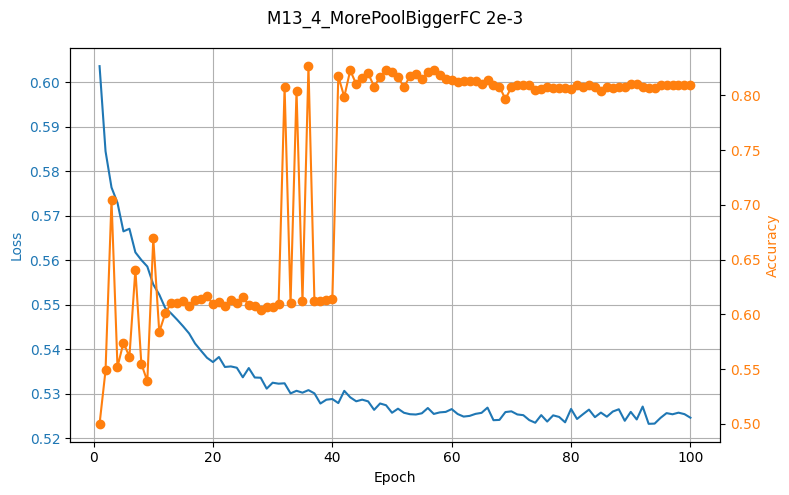

(0.8267543859649122, 0.823982398239824)

In [54]:
# run_experiment(Model8_Bottleneck1x1, "Model_8", 100)
# run_experiment(Model9_VGGLite, "Model_9", 100)
# run_experiment(Model10_MorePooling, "Model_10", 100)
# run_experiment(Model11_CappedChannels, "Model_11", 100)
# run_experiment(Model12_ShrinkBeforeFC, "Model_12", 100)
# run_experiment(Model15_2conv_stages, "Model_15", 100)
# run_experiment(Model22_extra_conv_mid, "Model_22", 100)
# run_experiment(Model14_VGGmini_morepool, "Model_14", 100)
# run_experiment(Model21_late64, "Model_21", 100)
# run_experiment(Model20_all32, "Model_20", 100)
# run_experiment(Model13_VGGmini, "Model_13", 100)
# run_experiment(Model16_wide_early, "Model_16", 100)
# run_experiment(Model17_deeper_4blocks, "Model_17", 100)
# run_experiment(Model18_bigger_head, "Model_18", 100)
# run_experiment(Model19_lowchan_deeper, "Model_19", 100)
# run_experiment(M6_1_WiderEarly, "M6_1_WiderEarly", 100)
# run_experiment(M6_2_StrongerLate, "M6_2_StrongerLate", 100)
# run_experiment(M6_3_ExtraConvMid, "M6_3_ExtraConvMid", 100)
# run_experiment(M6_4_BiggerHead, "M6_4_BiggerHead", 100)
# run_experiment(M6_5_BottleneckMid, "M6_5_BottleneckMid", 100)
# run_experiment(M13_1_ExtraConvEarly, "M13_1_ExtraConvEarly", 100)
# run_experiment(M13_2_Wider, "M13_2_Wider", 100)
# run_experiment(M13_3_Extra1x1Late, "M13_3_Extra1x1Late", 100)
# run_experiment(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC", 100)
# run_experiment(M13_5_WithDropout, "M13_5_WithDropout", 100)
# run_experiment(M19_1_SlightlyWider, "M19_1_SlightlyWider", 100)
# run_experiment(M19_2_LastTo32, "M19_2_LastTo32", 100)
# run_experiment(M19_3_ExtraConvMid, "M19_3_ExtraConvMid", 100)
# run_experiment(M19_4_BottleneckBeforeC3, "M19_4_BottleneckBeforeC3", 100)
# run_experiment(M19_5_BiggerHead, "M19_5_BiggerHead", 100)

# run_experiment_new(Model13_VGGmini, "Model_13 1e-3", 100, lr = 1e-3)
# run_experiment(Model13_VGGmini, "Model_13 1e-3", 100)

# run_experiment_new(Model13_VGGmini, "Model_13 3e-4", 100, lr = 3e-4)
# run_experiment_new(Model13_VGGmini, "Model_13 5e-4", 100, lr = 5e-4)
# run_experiment_new(Model13_VGGmini, "Model_13 2e-3", 100, lr = 2e-3)

# LR VARIATIOn
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 1e-3", 100, lr = 1e-3, min_lr = 1e-8)
run_experiment(SmallKerasLikeQuantCNN, "Model_6 1e-3", 100)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 3e-4", 100, lr = 3e-4, min_lr = 1e-8)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 5e-4", 100, lr = 5e-4, min_lr = 1e-8)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 2e-3", 100, lr = 2e-3, min_lr = 1e-8)


run_experiment_new(Model19_lowchan_deeper, "Model_19 1e-3", 100, lr = 1e-3, min_lr = 1e-8)
run_experiment(Model19_lowchan_deeper, "Model_19 1e-3", 100)
run_experiment_new(Model19_lowchan_deeper, "Model_19 3e-4", 100, lr = 3e-4, min_lr = 1e-8)
run_experiment_new(Model19_lowchan_deeper, "Model_19 5e-4", 100, lr = 5e-4, min_lr = 1e-8)
run_experiment_new(Model19_lowchan_deeper, "Model_19 2e-3", 100, lr = 2e-3, min_lr = 1e-8)


run_experiment_new(M13_3_Extra1x1Late, "M13_3_Extra1x1Late 1e-3", 100, lr = 1e-3, min_lr = 1e-8)
run_experiment(M13_3_Extra1x1Late, "M13_3_Extra1x1Late 1e-3", 100)
run_experiment_new(M13_3_Extra1x1Late, "M13_3_Extra1x1Late 3e-4", 100, lr = 3e-4, min_lr = 1e-8)
run_experiment_new(M13_3_Extra1x1Late, "M13_3_Extra1x1Late 5e-4", 100, lr = 5e-4, min_lr = 1e-8)
run_experiment_new(M13_3_Extra1x1Late, "M13_3_Extra1x1Late 2e-3", 100, lr = 2e-3, min_lr = 1e-8)

run_experiment_new(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC 1e-3", 100, lr = 1e-3, min_lr = 1e-8)
run_experiment(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC 1e-3", 100)
run_experiment_new(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC 3e-4", 100, lr = 3e-4, min_lr = 1e-8)
run_experiment_new(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC 5e-4", 100, lr = 5e-4, min_lr = 1e-8)
run_experiment_new(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC 2e-3", 100, lr = 2e-3, min_lr = 1e-8)
